# Delays and offsets

To validate our results we look at different delays and offsets. The goal here is to analyse the effect of different prior delays and different game offsets.

In [1]:
""" Imports
"""
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import arviz as az

sys.path.append("../")
sys.path.append("../covid19_inference/")

import covid19_inference as cov19
import covid19_soccer
from covid19_soccer.plot.utils import lighten_color


""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Taken from Paul Spitzner: makeitso.one and https://personal.sron.nl/~pault/
"""
colors = {
    "data":"#060434", #black
    "fraction":"#33BBEE", #cyan
    "cases":  "#0077BB",# teal
    "male": "#EE7733", #orange
    "female":"#EE3377", # magenta
    "Repr": "#009988", # blue
    "c": "#e5f6ff2",
    "d": "#f2f4f8",
}

""" General configs
"""
fig_path = "./figures/validation"
countries = ["England","Scotland","Germany","France"]
tune=1000
draws=1500
max_treedepth=12

kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

""" Utiliy functions
"""
# Load traces
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
def get_from_trace(var,trace):
    """ Reshapes and returns an numpy array from an arviz trace
    """
    var = np.array(trace.posterior[var])
    var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    return var

def plot_relative_from_soccer(traces, models, dls, variable, begin=None, end=None,violin=False,verbose=True):
    
    # End and start day for sum of cases
    if begin is None:
        begin = datetime.datetime(2021,6,11)
    if end is None:
        end = datetime.datetime(2021,7,11)

    # Create figure
    fig,ax=plt.subplots(1,1,figsize=(7,2.7))
    
    # Get params from trace and dataloader
    per = []
    for i, trace in enumerate(traces):
        new_E_t = get_from_trace('new_E_t',trace)
        S_t = get_from_trace('S_t',trace)
        new_I_t = get_from_trace('new_I_t',trace)
        R_t_base = get_from_trace('R_t_base',trace) + get_from_trace('R_t_add_noise_fact',trace)[...,0]
        C_base = get_from_trace('C_base',trace)
        C_soccer = get_from_trace('C_soccer',trace)
        R_t_soccer = get_from_trace('R_t_soccer',trace)
        pop = model.N_population
        i_begin = (begin-model.sim_begin).days
        i_end = (end-model.sim_begin).days + 1 #inclusiv last day
    
        """ Calculate cases in agegroup because of soccer and without soccer
        """
        # d is draws
        # t is time
        # i,j is gender
        R_t_ij_base = np.einsum("dt,dij->dtij",R_t_base,C_base)
        infections_base = S_t/pop*np.einsum("dti,dtij->dti", new_E_t, R_t_ij_base)

        R_t_ij_soccer = np.einsum("dt,dij->dtij",R_t_soccer,C_soccer)
        infections_soccer = S_t/pop*np.einsum("dti,dtij->dtj", new_E_t, R_t_ij_soccer)

        # Sum over the choosen range (i.e. month of uefa championship) male and femal
        num_infections_base = np.sum(infections_base[...,i_begin:i_end,:], axis=-2)
        num_infections_soccer = np.sum(infections_soccer[...,i_begin:i_end,:], axis=-2)

        # Create pandas dataframe for easy violin plot
        ratio_soccer = num_infections_soccer/(num_infections_base+num_infections_soccer)
        male = np.stack((ratio_soccer[:,0],np.zeros(ratio_soccer[:,0].shape)),axis=1)
        female = np.stack((ratio_soccer[:,1],np.ones(ratio_soccer[:,1].shape)),axis=1)

        percentage = pd.DataFrame(np.concatenate((male,female)),columns=["percentage_soccer","gender"])
        percentage["gender"] = pd.cut(percentage["gender"], bins=[-1,0.5,1], labels=["male","female"])
        percentage["percentage_soccer"] = percentage["percentage_soccer"]*100
        percentage["percentage_soccer"] = percentage["percentage_soccer"].astype('float64')
        percentage["percentage_soccer"] = percentage["percentage_soccer"]+np.random.normal(size=len(percentage["percentage_soccer"]),loc=0,scale=0.0001)
        percentage['variable'] = variable[i]
        
        if verbose:
            print(f"CI [50,2.5,97.5] {dl.countries} Variable {variable[i]}")
            print(f"\tmale {np.percentile(ratio_soccer[:,0], [50,2.5,97.5])}")
            print(f"\tfemale {np.percentile(ratio_soccer[:,1], [50,2.5,97.5])}")
        per.append(percentage)
    
    percentage = pd.concat(per,axis=0)
    
    if violin:
        g = sns.violinplot(
            data=percentage,
            y="percentage_soccer",
            x="variable",
            hue="gender",
            scale="width",
            inner="quartile",
            orient="v",
            ax=ax,
            split=True,
            positions = variable,
            palette={"male": colors["male"], "female": colors["female"]},
            linewidth=1,
            saturation=1,
        )
        c = 1
        for col in ax.collections:
            col.set_edgecolor(colors["female"] if c%2==0 else colors["male"] ) # Set outline colors
            c= c+1
    else:
        g = sns.stripplot(
            data=percentage,
            y="percentage_soccer",
            x="variable",
            hue="gender",
            dodge=True,
            palette={"male": colors["male"], "female": colors["female"]},
            alpha=.25,
            zorder=1,
            size=2
        )
        sns.pointplot(
            y="percentage_soccer",
            x="variable",
            hue="gender",
            data=percentage,
            dodge=.8 - .8 / 3,
            join=False,
            palette={"male": lighten_color(colors["male"],1.3), "female": lighten_color(colors["female"],1.3)},
            markers="d",
            ci=95,
            scale = 0.6
        )
        
    ax.legend([],[], frameon=False)
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()

    #ax.set_xticklabels([)
    
    
    ax.set_ylabel("Percentage of soccer related\ninfections during the Championship")
    #ax.set_xlabel("")
    #ax.set_xticks([])
    ax.axhline(0,color="tab:gray",ls="--",zorder=-5)
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_visible(False)

    return ax

def plot_delays(traces):
    fig,axes = plt.subplots(1,len(traces),figsize=(len(traces)*2.7,2.7))
    
    for i, trace in enumerate(traces):
        covid19_soccer.plot.distribution(
            model,
            trace,
            "delay",
            nSamples_prior=1000,
            title="",
            dist_math="D",
            ax=axes[i],
        )
    return axes


## Simple analysis only varying one parameter offset or delay respectivly

In [15]:
# Offset
offsets = [-35,-28,-8,-6,-4,-2,-1, 0, 1, 2, 4, 6, 8, 28, 35]
offsets = [-4,-2,-1, 0, 1, 2, 4]
models, traces, dls = [],[],[]

comp = {}

country = "France"
for offset in offsets:
    fstr=(f"/data.nst/jdehning/covid_uefa_traces2/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_games={offset}"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay={1.5}"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")   
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_games=offset)
    comp[f"{offset}"] = trace
    models.append(model)
    traces.append(trace)
    dls.append(dl)

In [16]:
model_compare = az.compare(comp)
#az.plot_compare(model_compare)
#plt.show()

/home/smohr/anaconda3/envs/uefa/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/smohr/anaconda3/envs/uefa/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [72]:
model_compare.to_csv(f"{fig_path}/comparison_models_{country}.csv")

Compute loo score for each trace

In [17]:
fig,axes = plt.subplots(2,1)

# Loo score

axes[0].errorbar(
    x=offsets,
    y=model_compare["loo"],
    yerr=model_compare["se"]*1.96,
    ls="",
    marker=".",
    capsize=2,
    color=colors["cases"]
)
axes[1].scatter(offsets,[l.p_loo for l in loo_scores],marker=".",color=colors["cases"])
axes[1].set_xlabel("offset")
axes[0].set_ylabel("elpd (log-score)")
axes[1].set_ylabel("eff. num. parameters")

fig.tight_layout()

# Save figure as pdf and png        

plt.show()
fig.savefig(f"{fig_path}/fig_loo_{country}.pdf", **kwargs)
fig.savefig(f"{fig_path}/fig_loo_{country}.png", **kwargs)
plt.close(fig=fig)

NameError: name 'loo_scores' is not defined

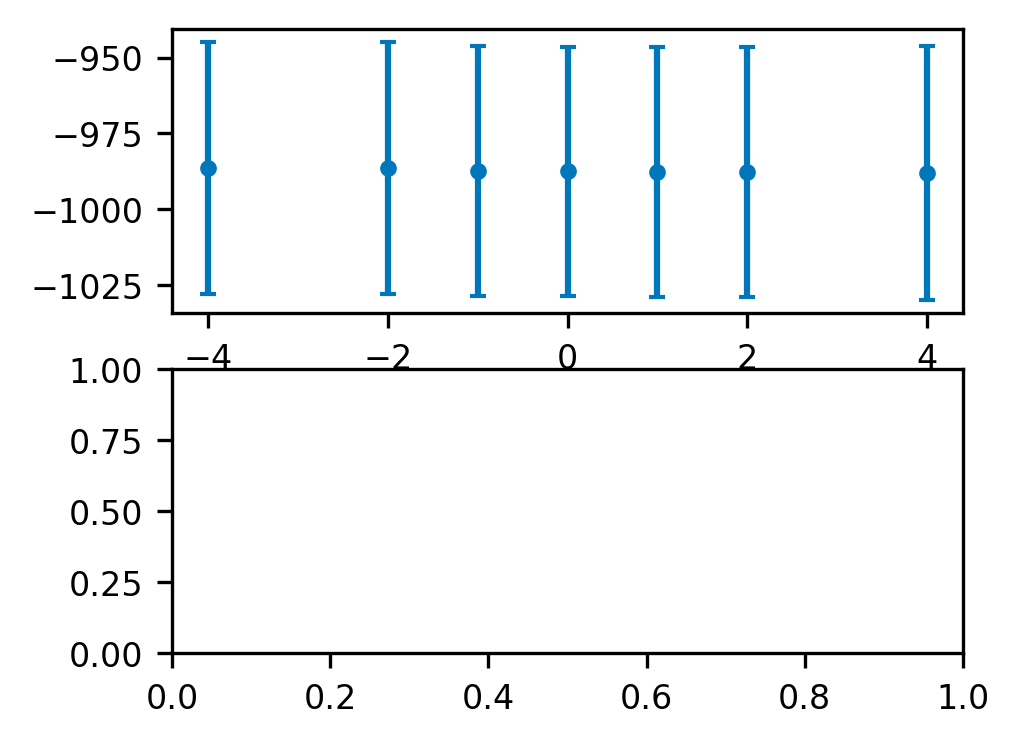

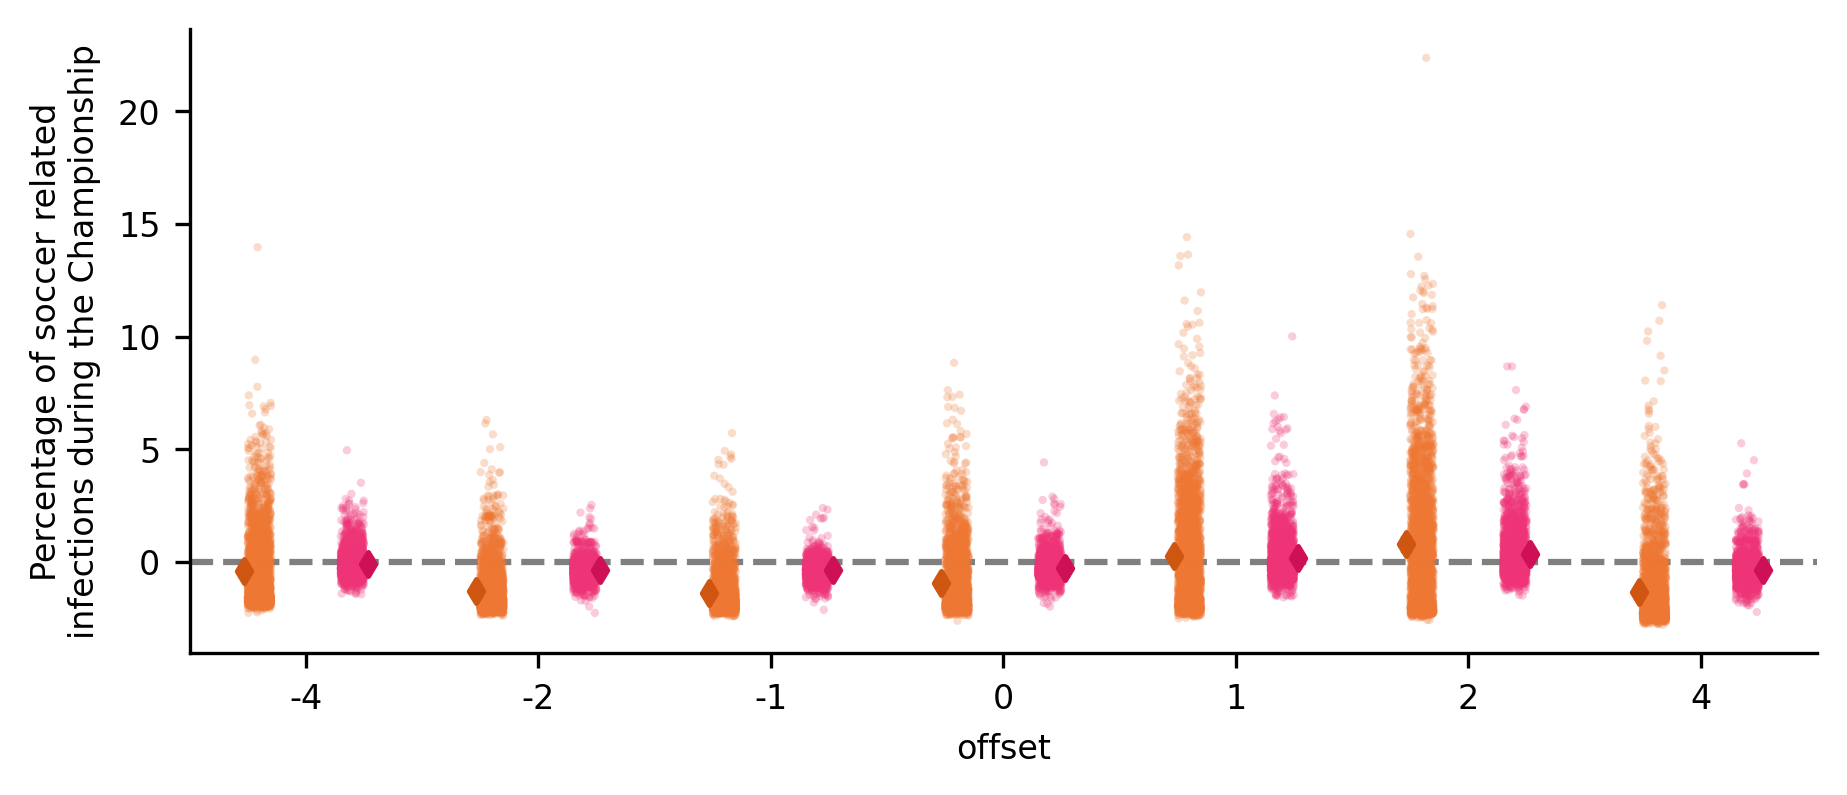

In [18]:
a = plot_relative_from_soccer(traces,models,dls,offsets,violin=False,verbose=False)
a.set_xlabel("offset")

fig=a.get_figure()
#a.set_ylim(-10,10)
fig.savefig(f"{fig_path}/fig_offset_overview_{country}.pdf", **kwargs)
fig.savefig(f"{fig_path}/fig_offset_overview_{country}.png", **kwargs)
plt.show()
plt.close(fig=fig)

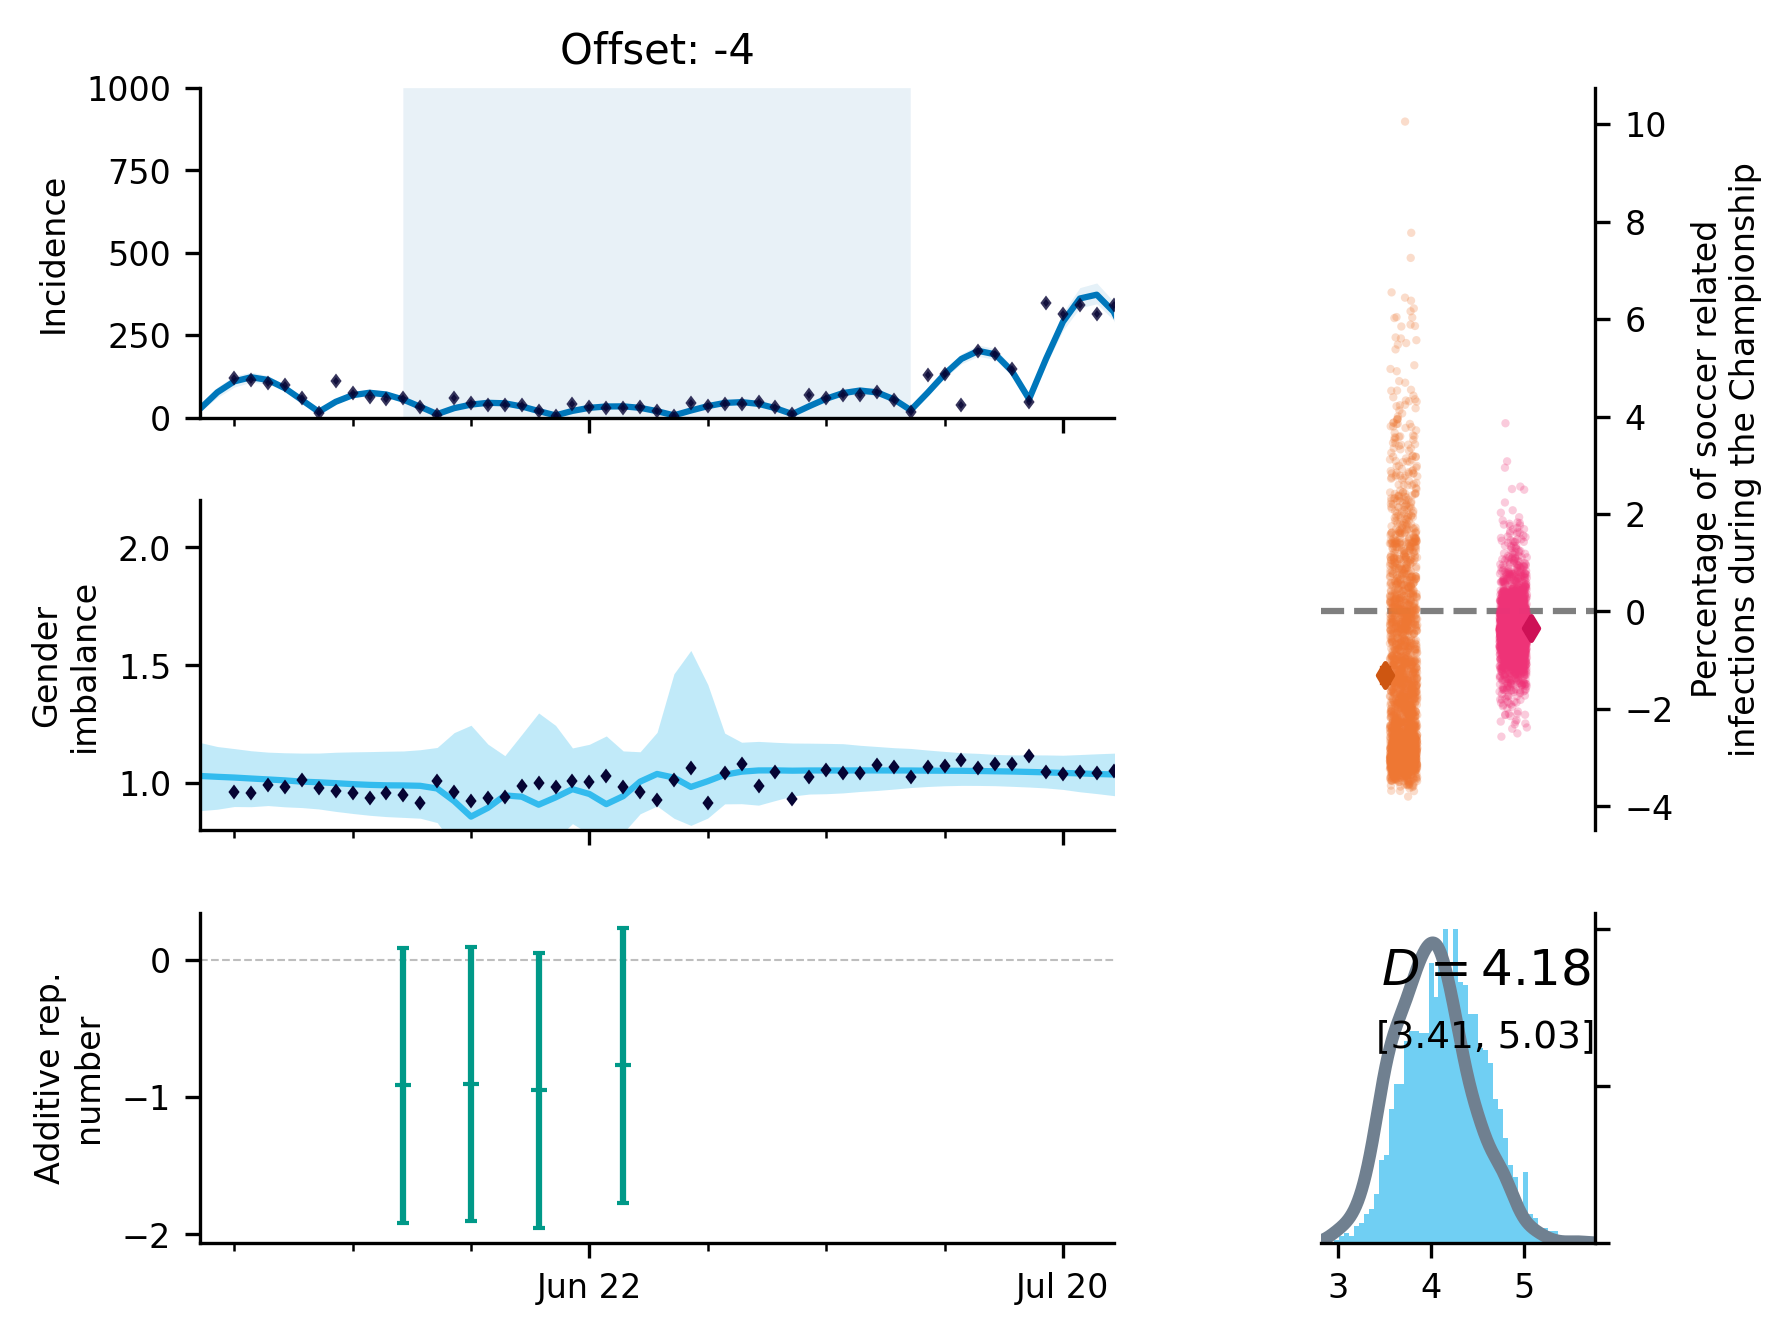

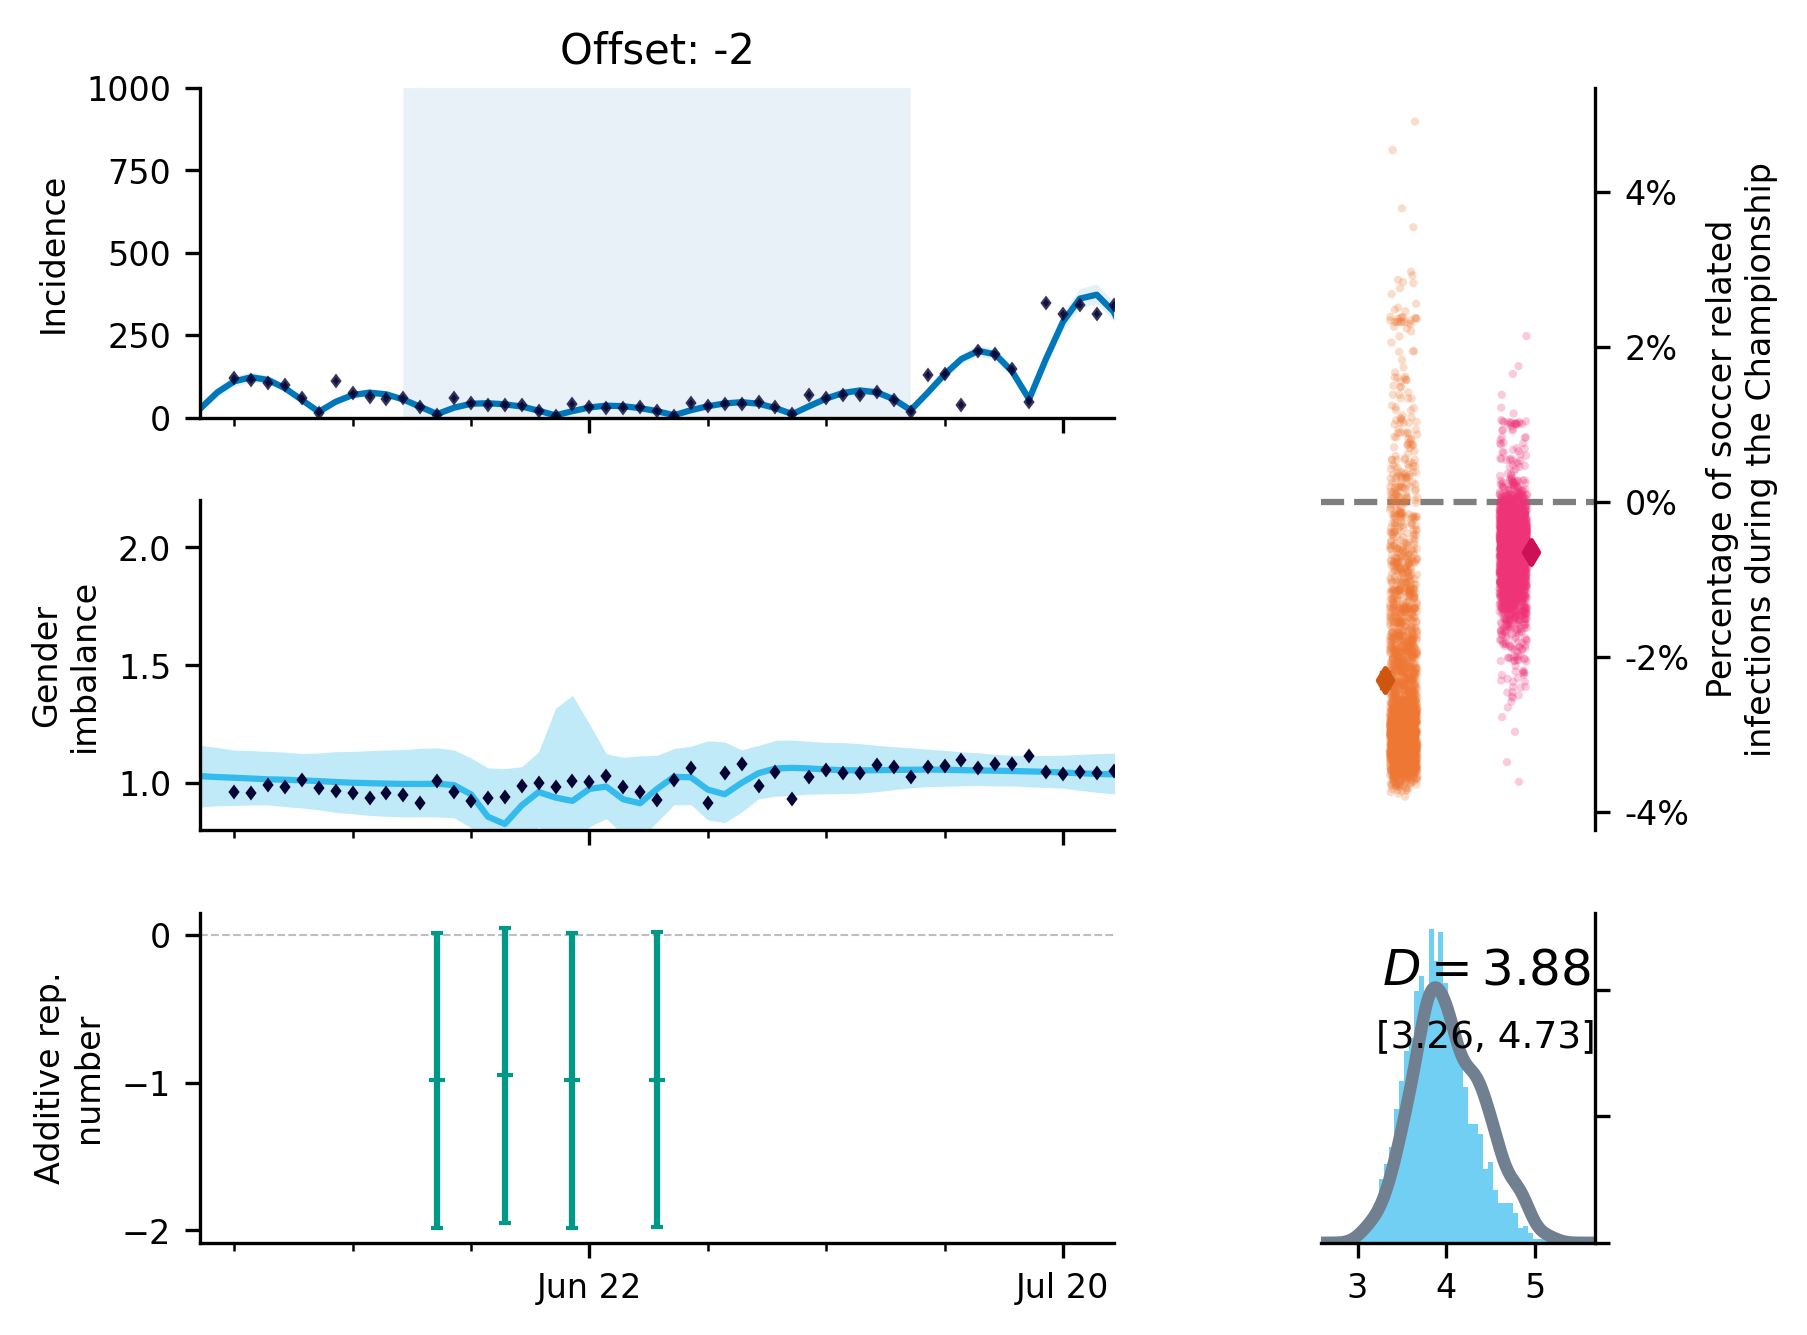

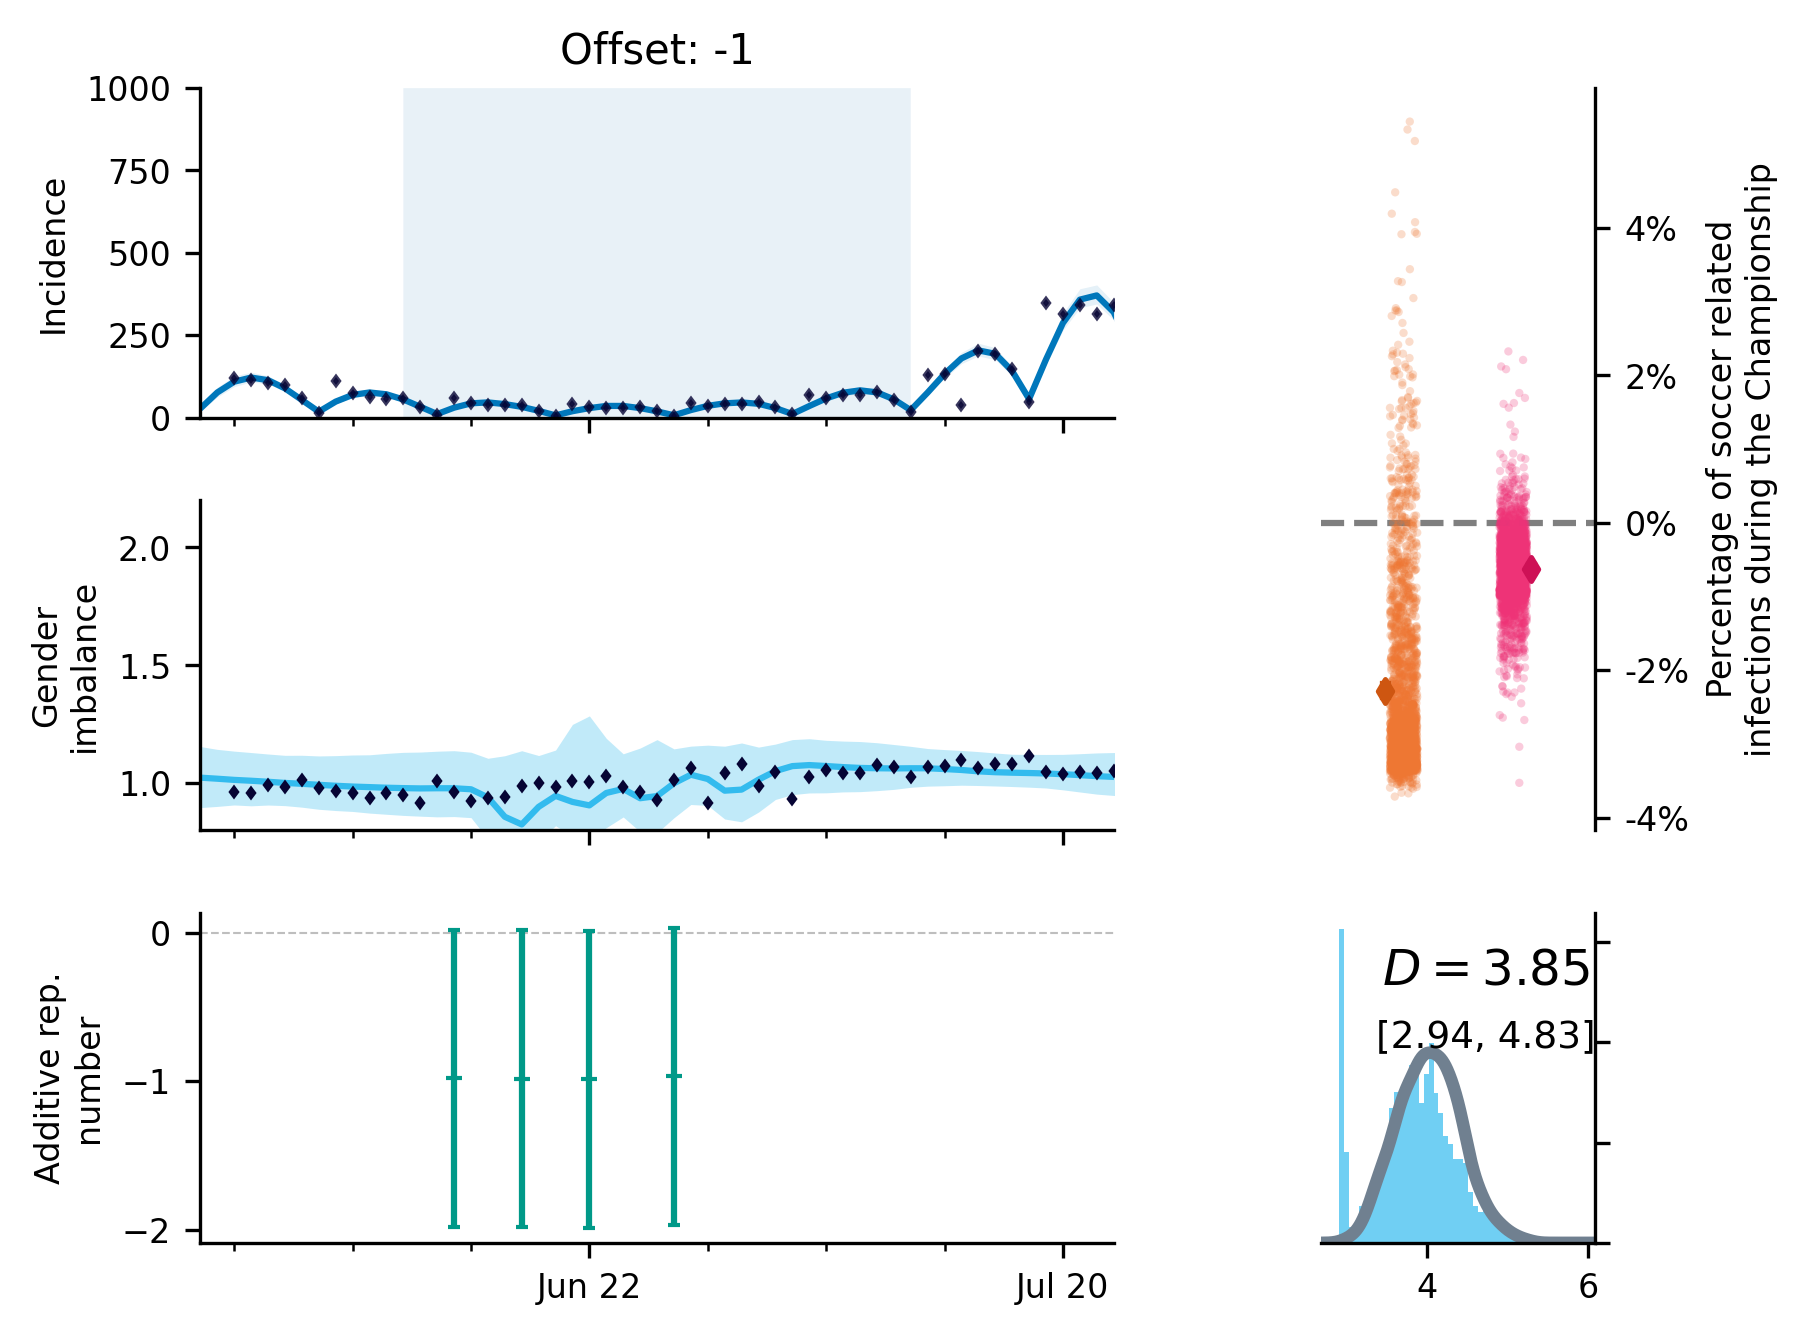

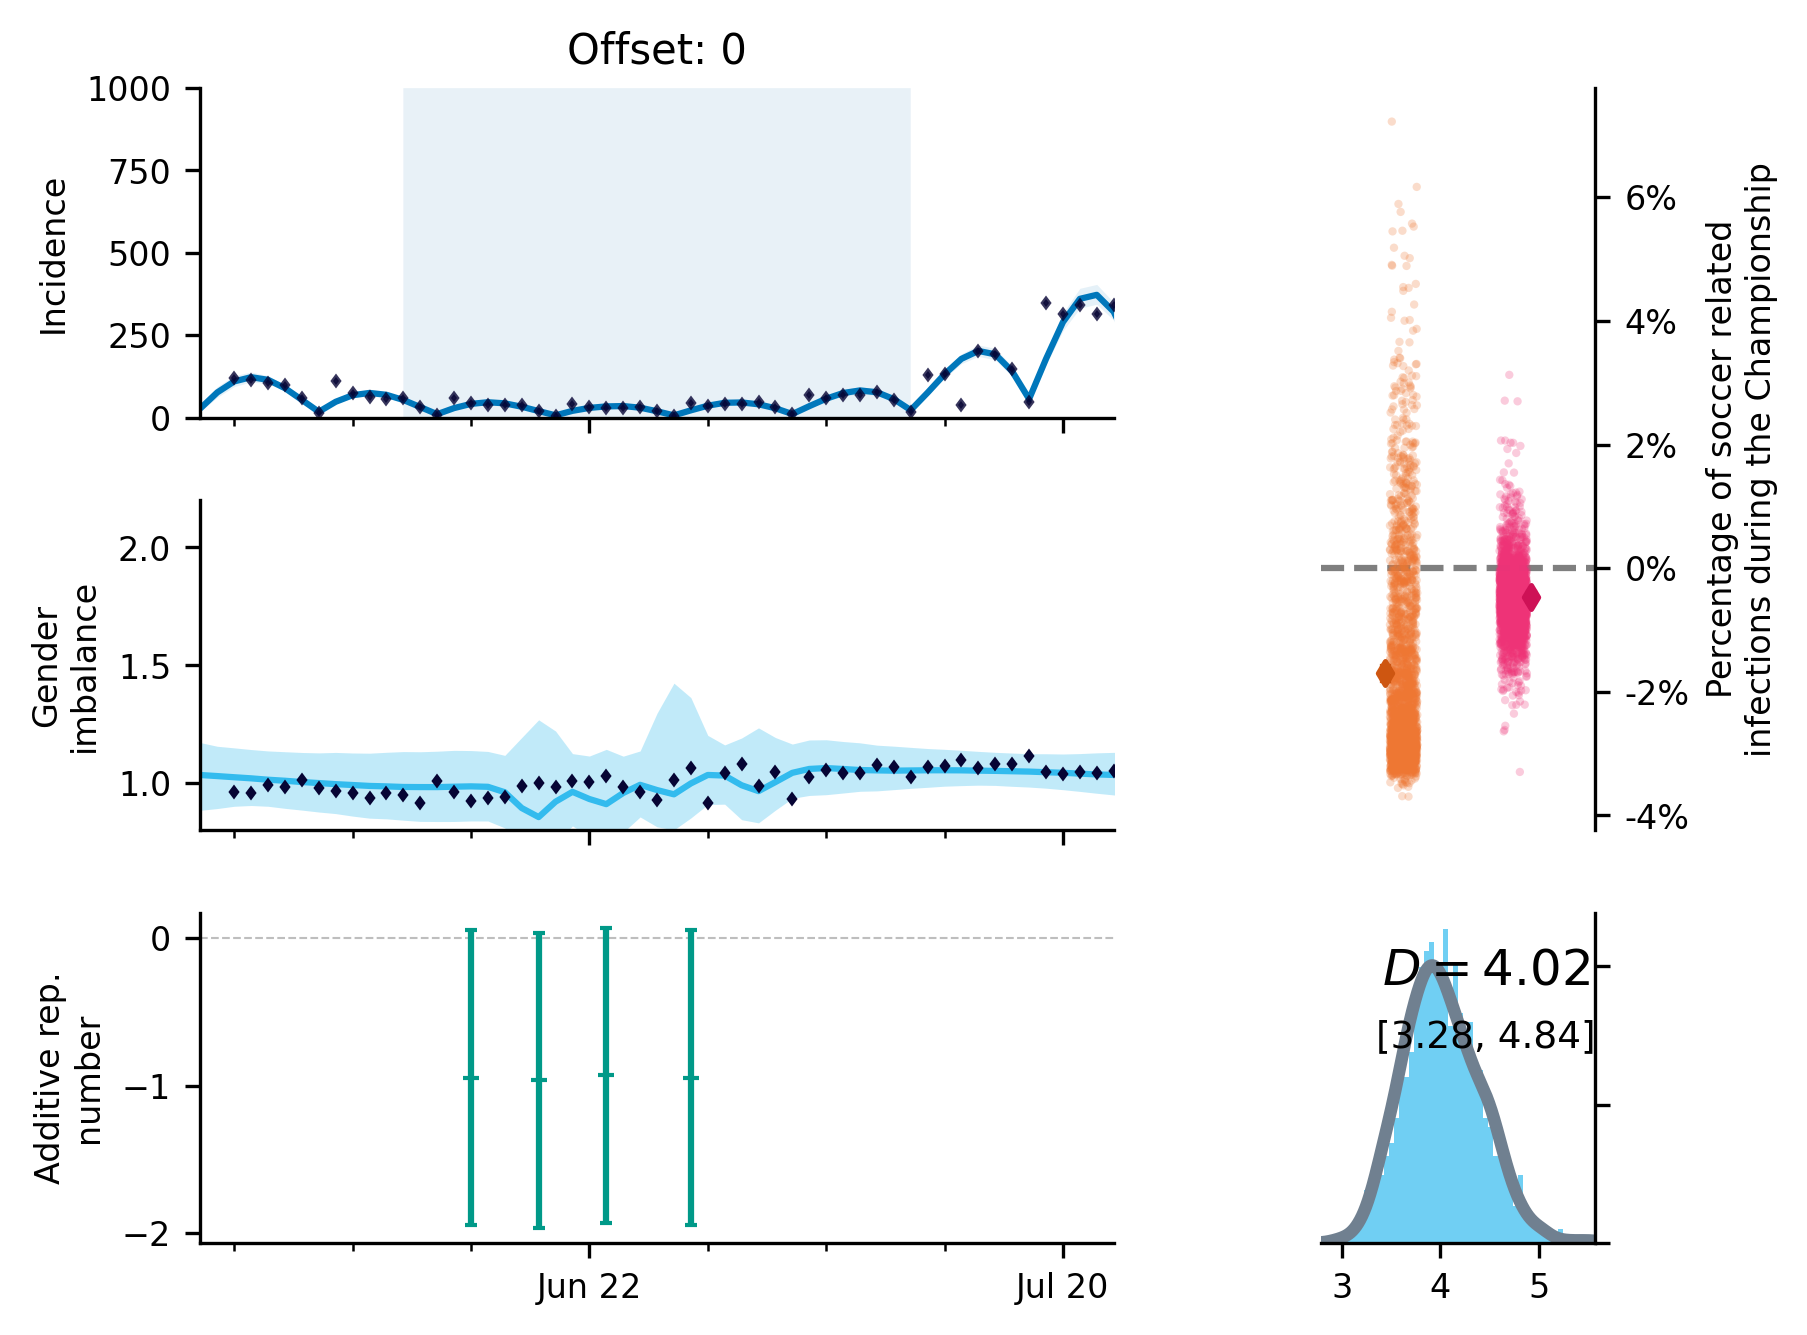

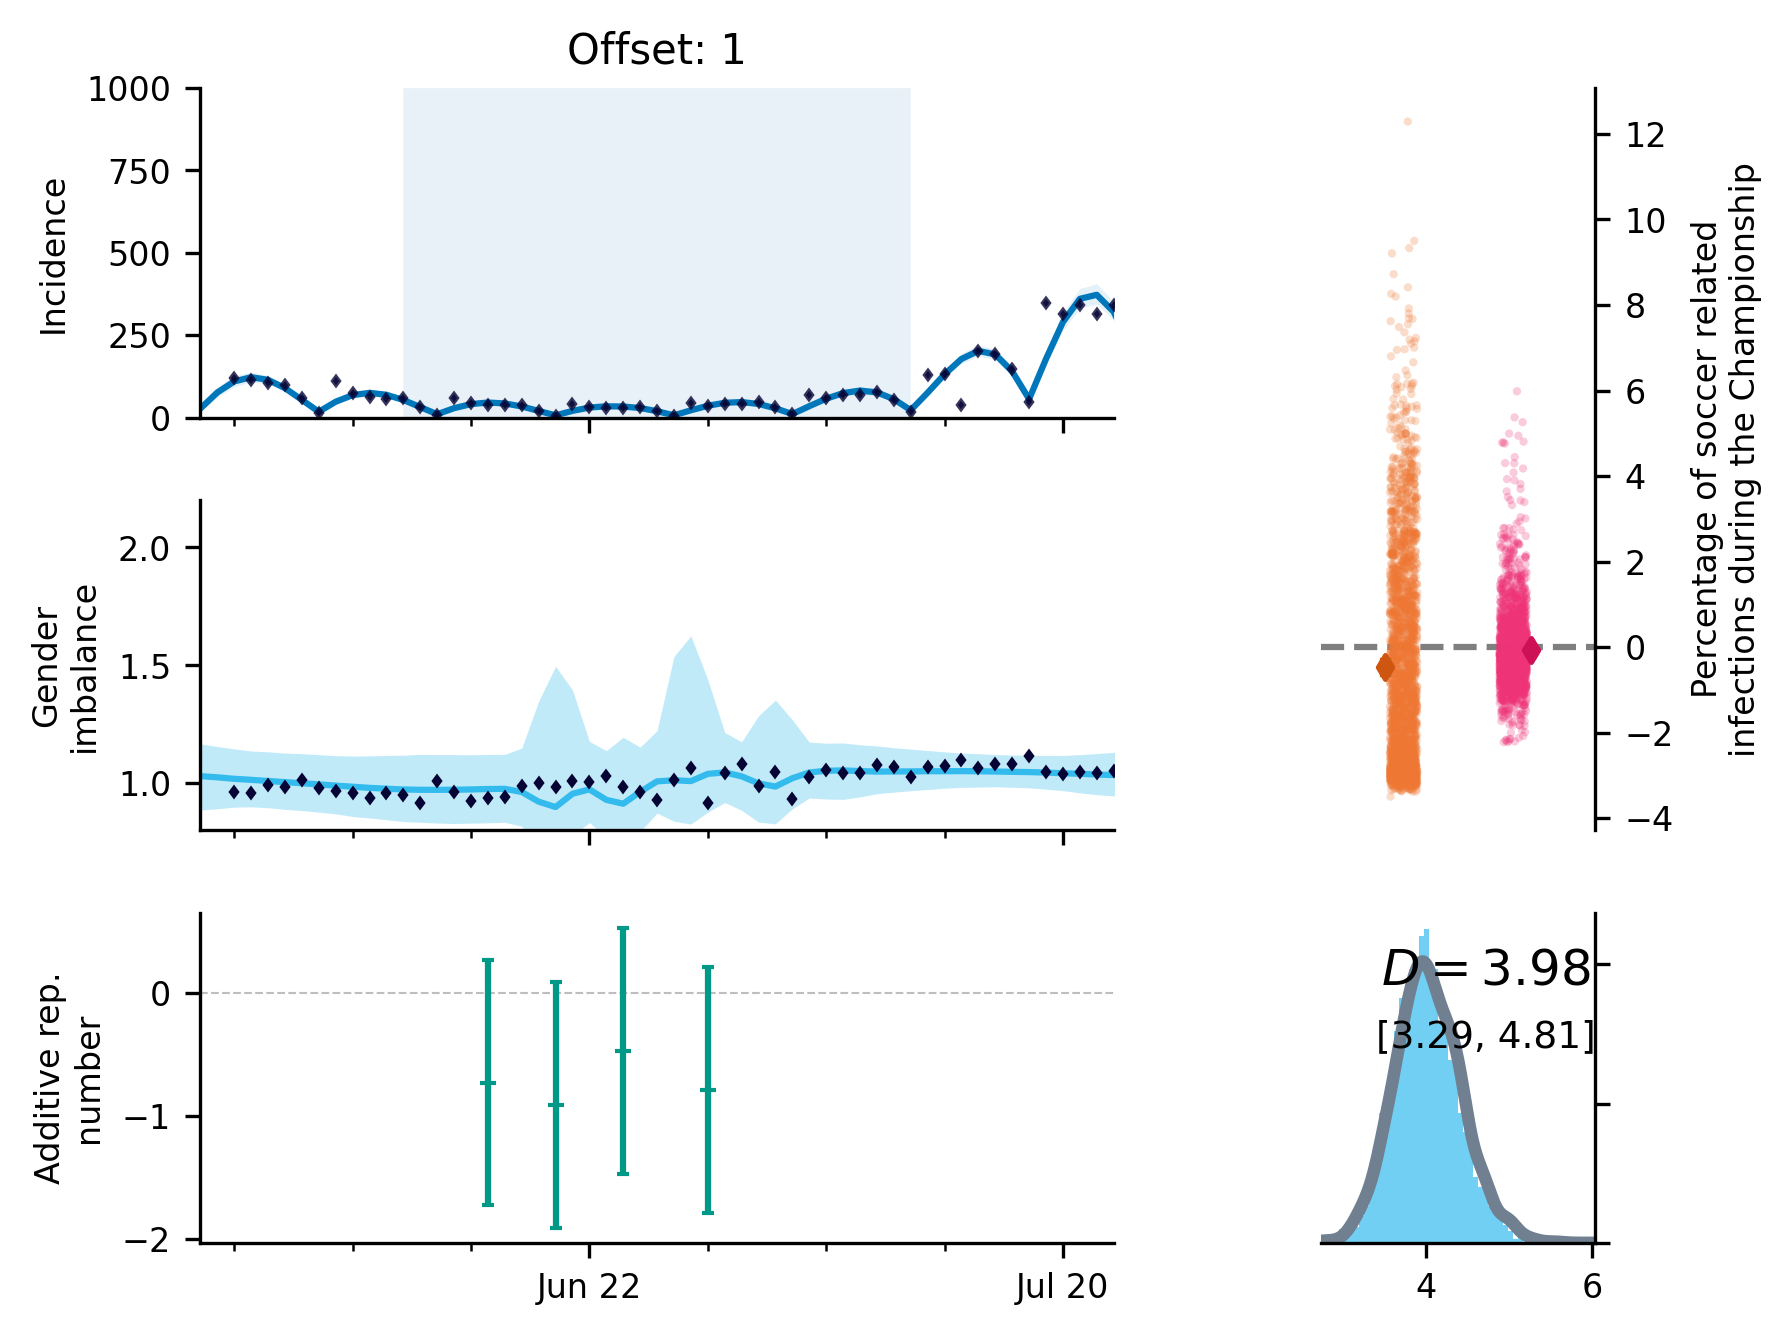

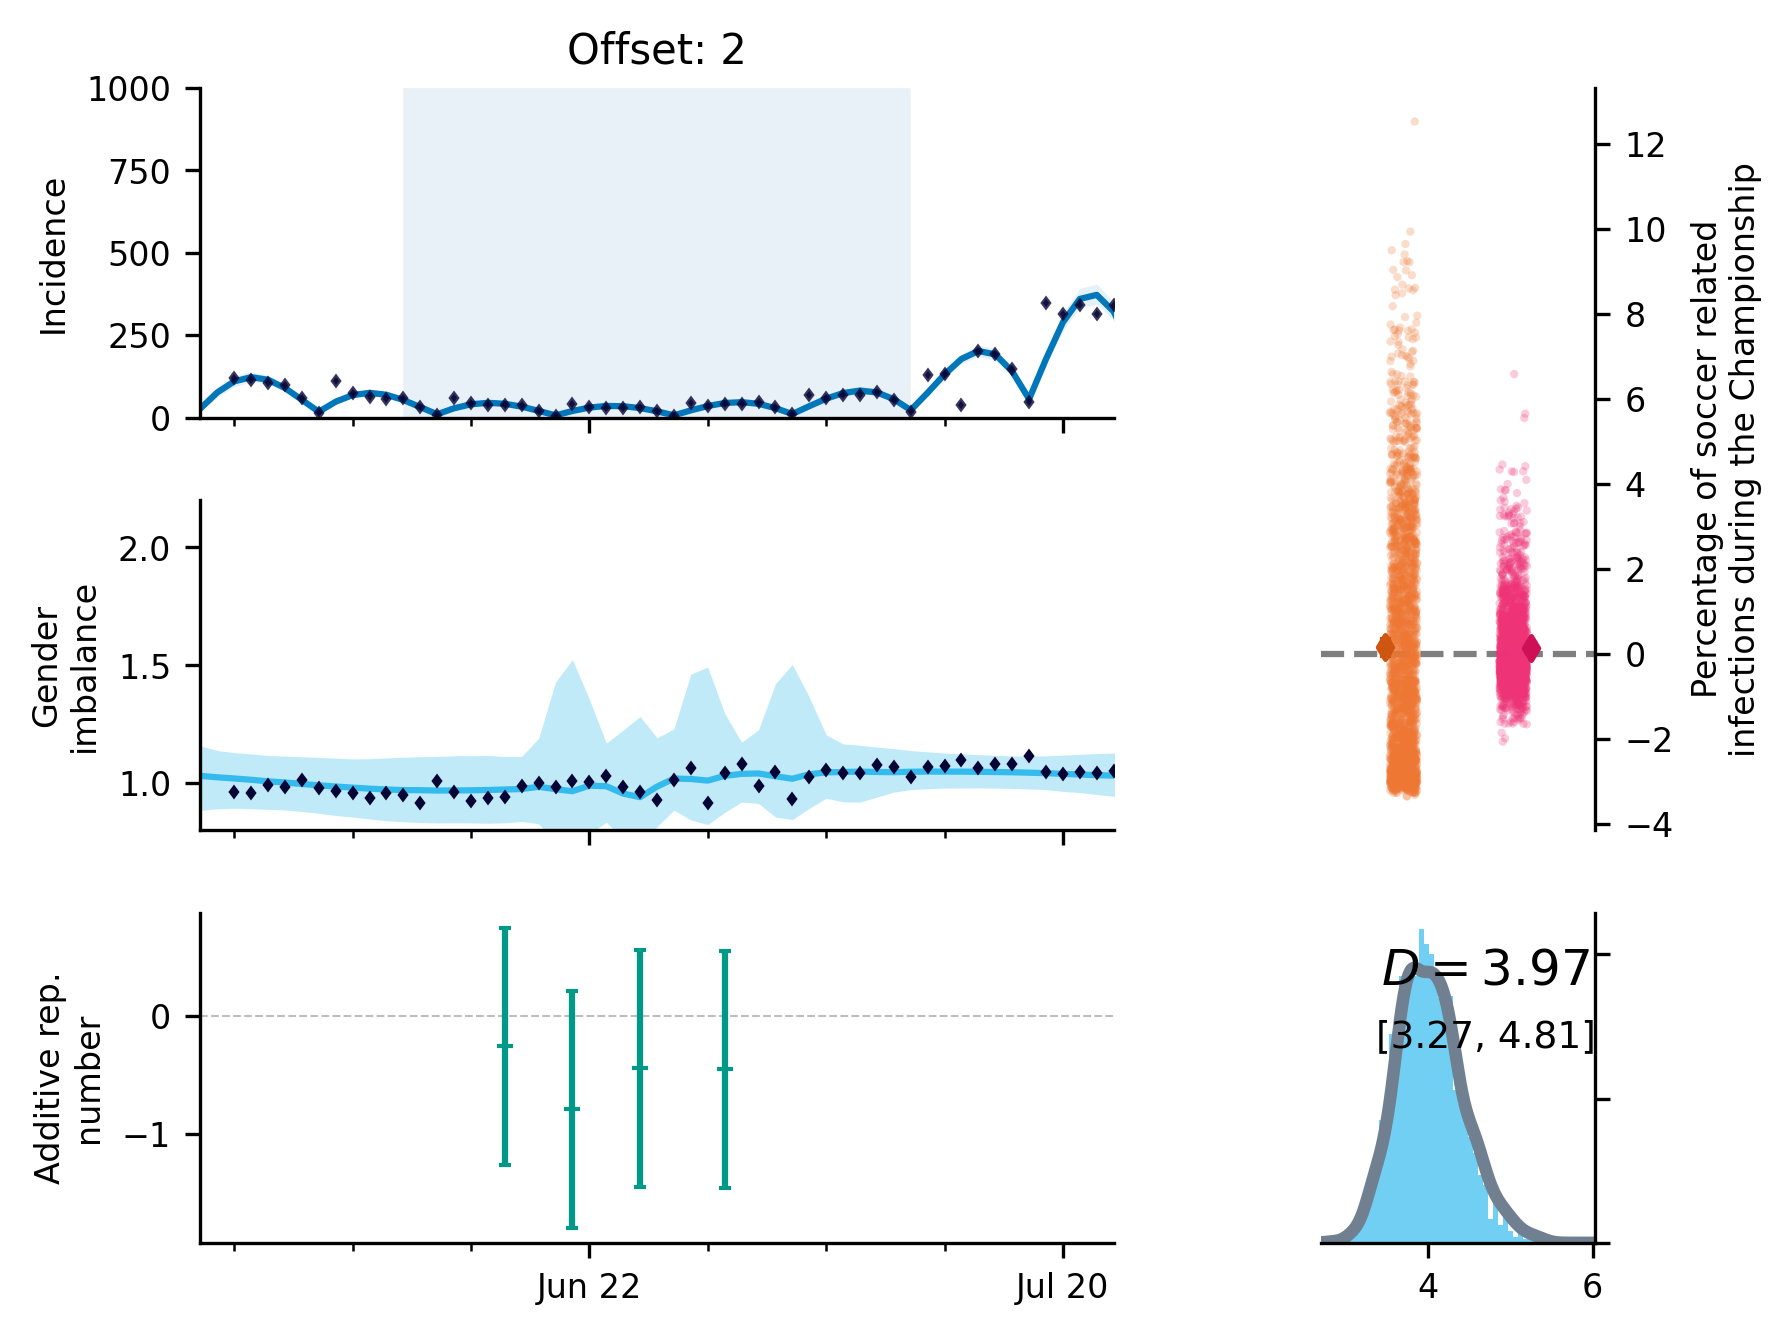

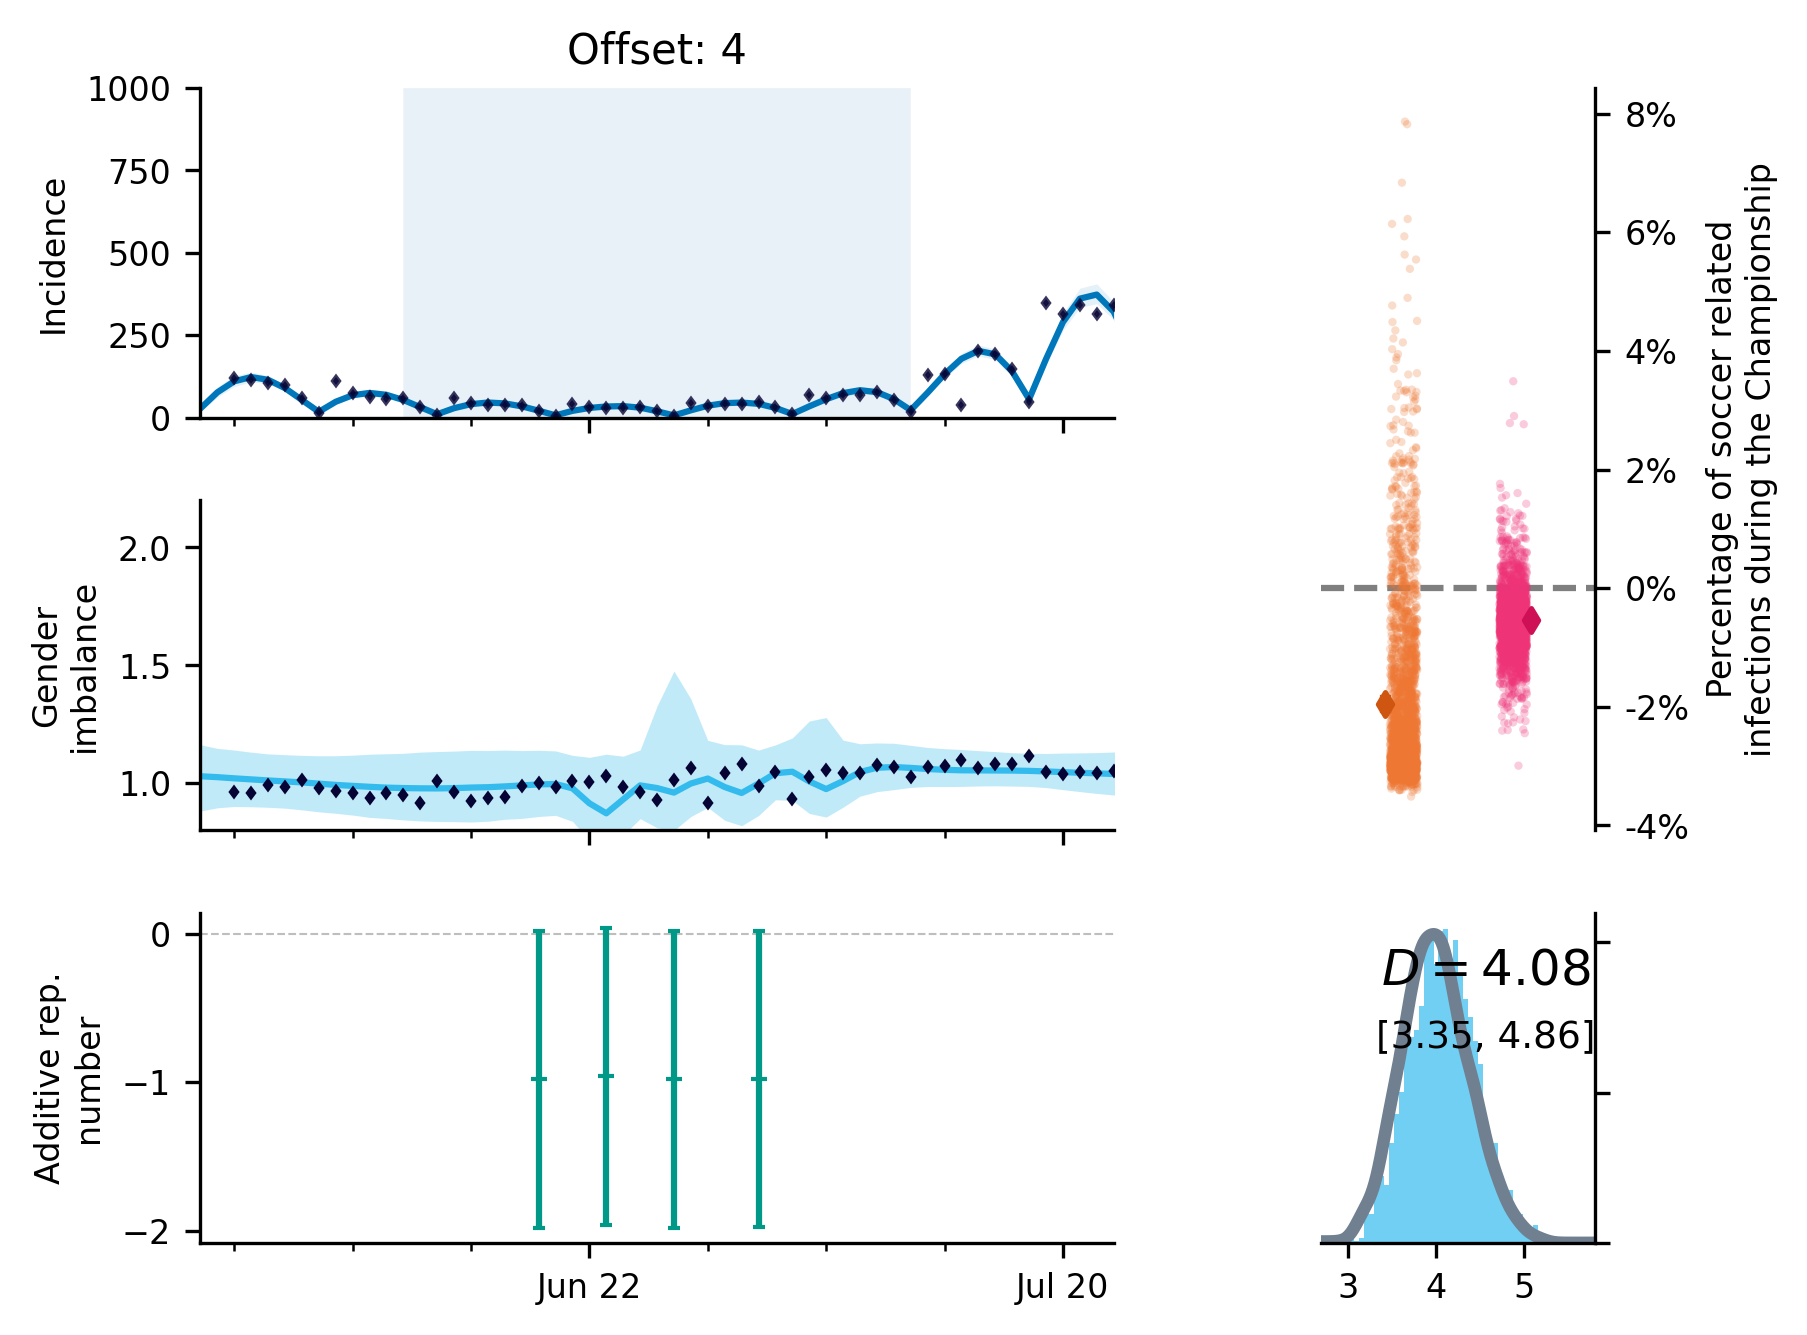

In [19]:
for i ,offset in enumerate(offsets):
    fig = covid19_soccer.plot.overview.plot_overview_single(
        traces[i],
        models[i],
        dls[i],
        ylim_fraction=[0.8,2.2],
        ylim_cases=[0,1000],
        ylim_relative=None,
        title=f"Offset: {offset}",
        verbose=False
    )
    fig.savefig(f"{fig_path}/fig_overview_{country}_off={offset}.pdf", **kwargs)
    fig.savefig(f"{fig_path}/fig_overview_{country}_off={offset}.png", **kwargs)
    plt.show()
    plt.close(fig=fig)


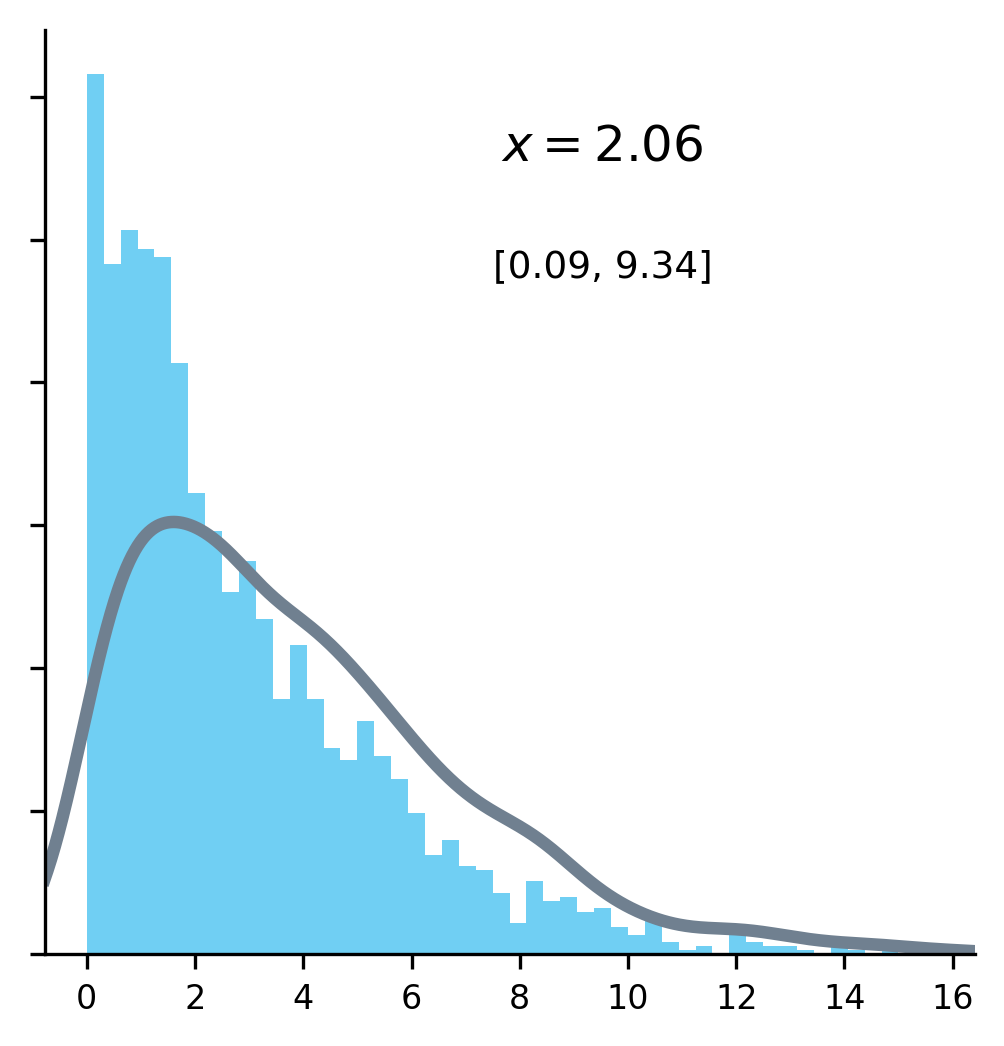

In [24]:
i=0
covid19_soccer.plot.distribution(
    models[i],
    traces[i],
    "sigma_alpha_g"
)
plt.show()

## Delay vs offset figure

### Scotland

In [98]:
# Offset
offsets = [-35,-28,-8,-6,-4,-2,-1, 0, 1, 2, 4, 6, 8, 28, 35]
models, traces, dls = [],[],[]

comp = {}

country = "Scotland"
for offset in offsets:
    fstr=(f"/data.nst/jdehning/covid_uefa_traces/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_games={offset}"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")   
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_games=offset)
    comp[f"{offset}"] = trace
    models.append(model)
    traces.append(trace)
    dls.append(dl)

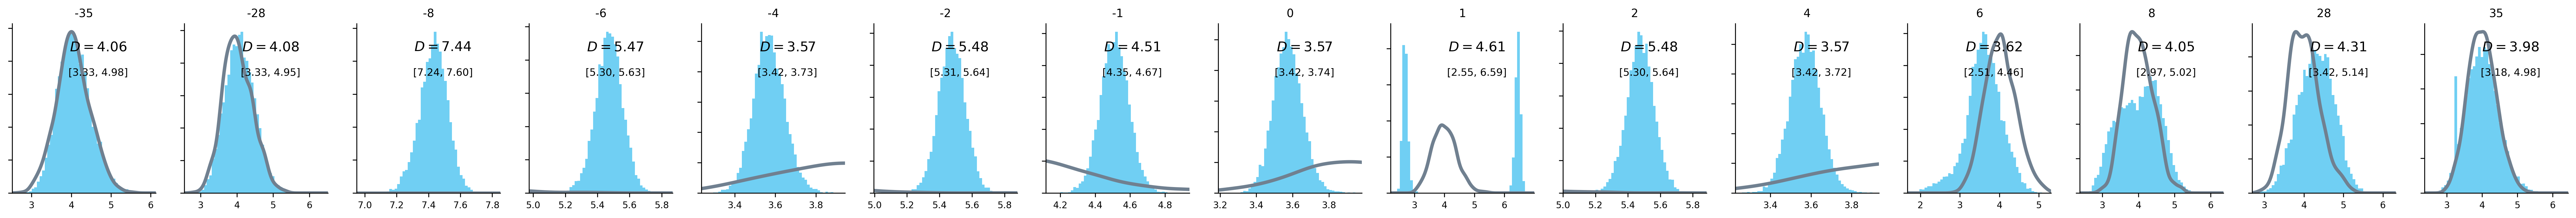

In [3]:
axes = plot_delays(traces)

for i,ax in enumerate(axes):
    ax.set_title(offsets[i])

plt.show()
plt.close(fig=axes[0].get_figure())

In [100]:
from sklearn.cluster import KMeans

# offset vs offset-delay
x = []
df = []
ci = []
for i, trace in enumerate(traces):
    # Get data from trace
    delay = get_from_trace("delay",trace)
    
    # Handpick cluster if two delays are found
    if offsets[i] == 1:
        kmeans = KMeans(n_clusters=2)
        kmeans.fit_transform(delay)
        
        # Stack ci together
        ci.append([offsets[i],np.percentile(delay[kmeans.labels_ == 0,0], [50,2.5,97.5])])
        ci.append([offsets[i],np.percentile(delay[kmeans.labels_ == 1,0], [50,2.5,97.5])])
    else: # Default case
        ci.append([offsets[i],np.percentile(delay[:,0], [50,2.5,97.5])])
        
    delay = np.stack((delay[:,0],np.ones(len(delay))*offsets[i]),axis=1)
    temp = pd.DataFrame(delay,columns=["Delay","Offset"])
    df.append(temp)

df = pd.concat(df)
df["Delay+Offset"] = df["Delay"]+df["Offset"]
df = df.sort_values("Offset")
df["Offset"] = df["Offset"].astype(int).astype(str)

The following figure showing the delays vs offsets only works for Scotland.

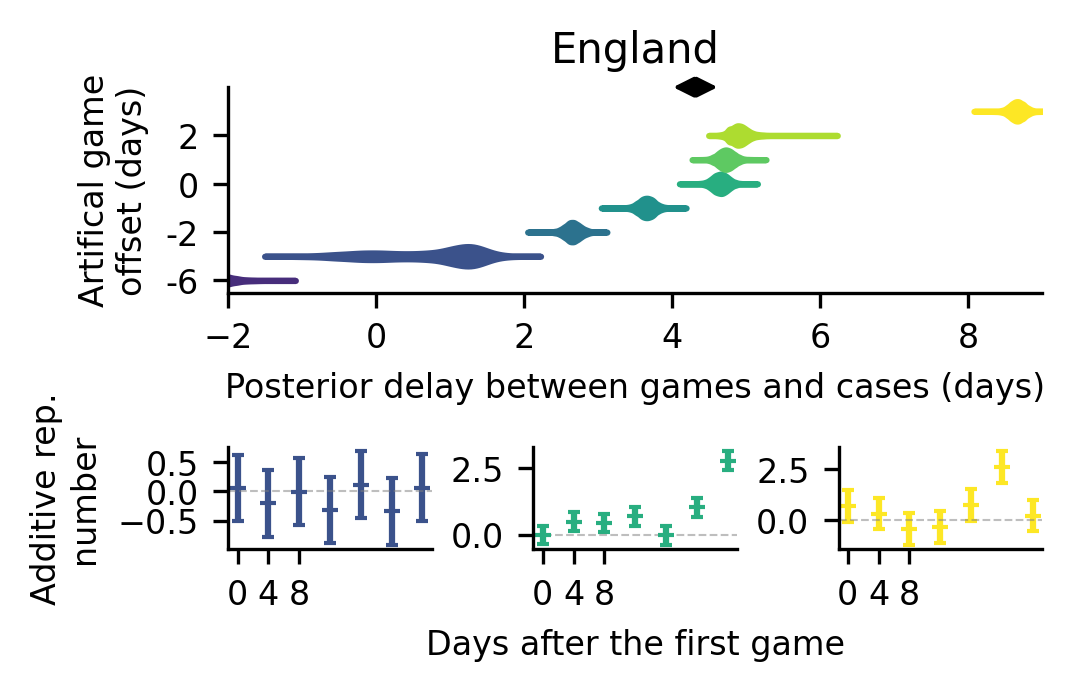

In [128]:
fig = plt.figure(figsize=(3.5,2))

grid = fig.add_gridspec(2, 3, wspace=0.5, hspace=1, height_ratios=[1.2,0.6])
selected_offsets = ["-6","-4","-2","-1","0","1","2","4"] #Scotland
cmap = sns.color_palette("viridis", as_cmap=True)
axes = []

# plot each delay posterior as scatter
axes.append(fig.add_subplot(grid[0,:]))
violin=True
if not violin:
    sns.stripplot(
        y="Offset", x="Delay+Offset",
        data=df[df["Offset"].isin(selected_offsets)],
        alpha=.15,
        zorder=1,
        size=1.1,
        jitter=0.035, # half width of the normal
        ax=axes[0],
        palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))]
    )
else:
    sns.violinplot(
        y="Offset", x="Delay+Offset",
        data=df[df["Offset"].isin(selected_offsets)],
        zorder=1,
        size=1.1,
        ax=axes[0],
        palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))],
        scale="count", inner=None,saturation=1
    )
    # Set outline colors
    for i,col in enumerate(axes[0].collections):
        col.set_edgecolor(cmap((i+1)/len(selected_offsets))) 

lower=np.where(np.array(offsets) == -6)[0][0]
upper=np.where(np.array(offsets) == 4)[0][0]
axes[0].set_ylim(-0.5,len(selected_offsets))
axes[0].set_xlim(-2,9)
axes[0].set_yticks([0,2,4,6])


# plot three handpicked offsets (one from each group)
for i,off in enumerate([-4,0,4]):
    axes.append(fig.add_subplot(grid[1,i]))
    covid19_soccer.plot.overview.plot_reproductionViolin(
        axes[i+1],
        traces[offsets.index(off)],
        models[offsets.index(off)],
        dls[offsets.index(off)],
        plot_dates=False,
        color=cmap((selected_offsets.index(str(off))+1)/len(selected_offsets))
    )
    
    # Markup
    axes[i+1].set_xticks([0,4,8])
    
    if i > 0:
        axes[i+1].set_ylabel("")

        
# Plot arrows
axes[0].annotate("",
    xy=(ci[offsets.index(-6)][1][0]-6, len(selected_offsets)), xycoords='data',
    xytext=(ci[offsets.index(-2)][1][0]-2, len(selected_offsets)), textcoords='data',
    arrowprops=dict(arrowstyle="<|-|>",
                    connectionstyle="arc3",
                    color="black",
                   ),
    )

axes[0].annotate("",
    xy=(ci[offsets.index(1)][1][0]+1, len(selected_offsets)), xycoords='data',
    xytext=(ci[offsets.index(1)+1][1][0]+1, len(selected_offsets)), textcoords='data',
    arrowprops=dict(arrowstyle="<|-|>",
                    connectionstyle="arc3",
                    color="black",
                   ),
    )


# Remove all top and right frames
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
        
axes[2].set_xlabel("Days after the first game")
axes[0].set_ylabel("Artifical game\noffset (days)")
axes[0].set_xlabel("Posterior delay between games and cases (days)")
axes[0].set_title(country)

# Show the conditional 
x = [c[0] for c in ci]
means = np.array([c[1][0] for c in ci]) + np.array(x)

kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig.savefig(f"{fig_path}/fig_delay_offset_{country}.pdf", **kwargs)
fig.savefig(f"{fig_path}/fig_delay_offset_{country}.png", **kwargs)
                
plt.show()
plt.close(fig=fig)

### England

In [107]:
# Offset
offsets = [-35,-28,-8,-6,-4,-2,-1, 0, 1, 2, 4, 6, 8, 28, 35]
models, traces, dls = [],[],[]

comp = {}

country = "England"
for offset in offsets:
    fstr=(f"/data.nst/jdehning/covid_uefa_traces/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_games={offset}"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")   
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_games=offset)
    comp[f"{offset}"] = trace
    models.append(model)
    traces.append(trace)
    dls.append(dl)

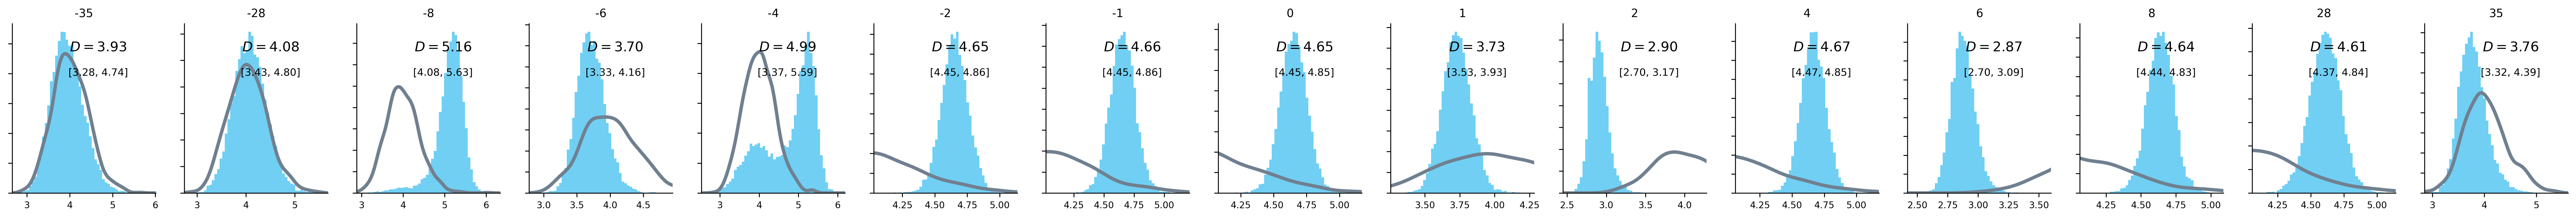

In [108]:
axes = plot_delays(traces)

for i,ax in enumerate(axes):
    ax.set_title(offsets[i])

plt.show()
plt.close(fig=axes[0].get_figure())

In [109]:
from sklearn.cluster import KMeans

# offset vs offset-delay
x = []
df = []
ci = []
for i, trace in enumerate(traces):
    # Get data from trace
    delay = get_from_trace("delay",trace)
    
    # Handpick cluster if two delays are found
    if offsets[i] == 100:
        kmeans = KMeans(n_clusters=2)
        kmeans.fit_transform(delay)
        
        # Stack ci together
        ci.append([offsets[i],np.percentile(delay[kmeans.labels_ == 0,0], [50,2.5,97.5])])
        ci.append([offsets[i],np.percentile(delay[kmeans.labels_ == 1,0], [50,2.5,97.5])])
    else: # Default case
        ci.append([offsets[i],np.percentile(delay[:,0], [50,2.5,97.5])])
        
    delay = np.stack((delay[:,0],np.ones(len(delay))*offsets[i]),axis=1)
    temp = pd.DataFrame(delay,columns=["Delay","Offset"])
    df.append(temp)

df = pd.concat(df)
df["Delay+Offset"] = df["Delay"]+df["Offset"]
df = df.sort_values("Offset")
df["Offset"] = df["Offset"].astype(int).astype(str)

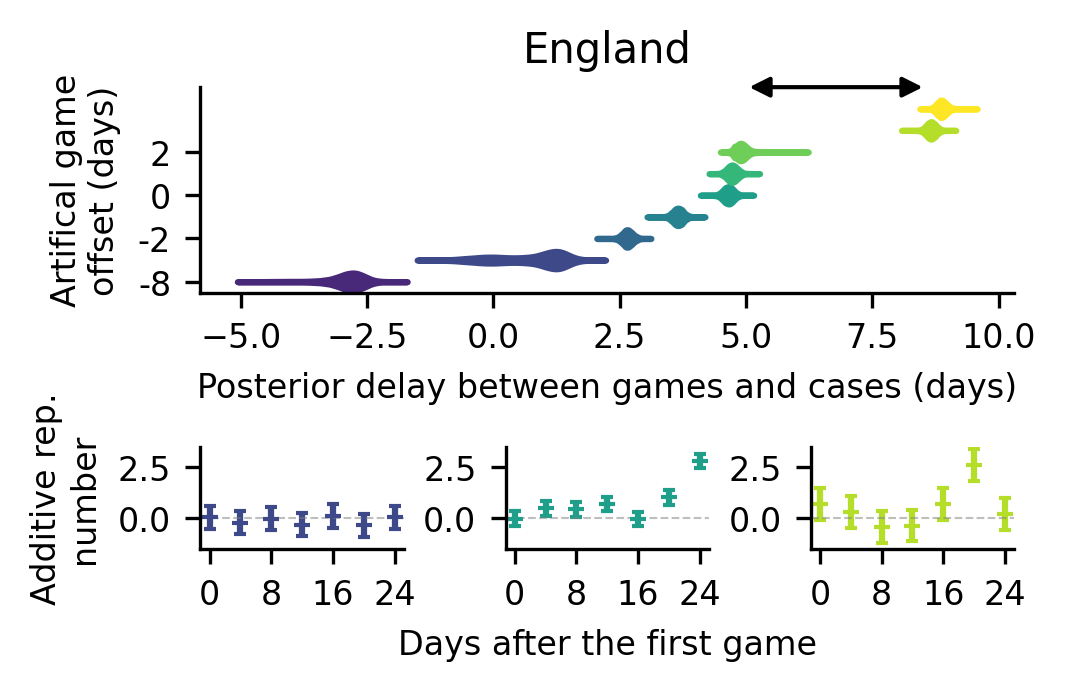

In [134]:
fig = plt.figure(figsize=(3.5,2))

grid = fig.add_gridspec(2, 3, wspace=0.5, hspace=1, height_ratios=[1.2,0.6])
selected_offsets = ["-8","-4","-2","-1","0","1","2","4","6"] #Scotland
cmap = sns.color_palette("viridis", as_cmap=True)
axes = []

# plot each delay posterior as scatter
axes.append(fig.add_subplot(grid[0,:]))
violin=True
if not violin:
    sns.stripplot(
        y="Offset", x="Delay+Offset",
        data=df[df["Offset"].isin(selected_offsets)],
        alpha=.15,
        zorder=1,
        size=1.1,
        jitter=0.035, # half width of the normal
        ax=axes[0],
        palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))]
    )
else:
    sns.violinplot(
        y="Offset", x="Delay+Offset",
        data=df[df["Offset"].isin(selected_offsets)],
        zorder=1,
        size=1.1,
        ax=axes[0],
        palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))],
        scale="count", inner=None,saturation=1
    )
    # Set outline colors
    for i,col in enumerate(axes[0].collections):
        col.set_edgecolor(cmap((i+1)/len(selected_offsets))) 

lower=np.where(np.array(offsets) == -6)[0][0]
upper=np.where(np.array(offsets) == 4)[0][0]
axes[0].set_ylim(-0.5,len(selected_offsets))
#axes[0].set_xlim(-2,9)
axes[0].set_yticks([0,2,4,6])


# plot three handpicked offsets (one from each group)
for i,off in enumerate([-4,0,4]):
    axes.append(fig.add_subplot(grid[1,i]))
    covid19_soccer.plot.overview.plot_reproductionViolin(
        axes[i+1],
        traces[offsets.index(off)],
        models[offsets.index(off)],
        dls[offsets.index(off)],
        plot_dates=False,
        color=cmap((selected_offsets.index(str(off))+1)/len(selected_offsets))
    )
    
    # Markup
    axes[i+1].set_xticks([0,8,16,24])
    axes[i+1].set_ylim(-1.5,3.5)
    if i > 0:
        axes[i+1].set_ylabel("")

        
# Plot arrows
axes[0].annotate("",
    xy=(ci[offsets.index(2)][1][0]+2, len(selected_offsets)), xycoords='data',
    xytext=(ci[offsets.index(4)][1][0]+4, len(selected_offsets)), textcoords='data',
    arrowprops=dict(arrowstyle="<|-|>",
                    connectionstyle="arc3",
                    color="black",
                   ),
    )


# Remove all top and right frames
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
        
axes[2].set_xlabel("Days after the first game")
axes[0].set_ylabel("Artifical game\noffset (days)")
axes[0].set_xlabel("Posterior delay between games and cases (days)")
axes[0].set_title(country)
        
# Show the conditional 
x = [c[0] for c in ci]
means = np.array([c[1][0] for c in ci]) + np.array(x)

kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig.savefig(f"{fig_path}/fig_delay_offset_{country}.pdf", **kwargs)
fig.savefig(f"{fig_path}/fig_delay_offset_{country}.png", **kwargs)
                
plt.show()
plt.close(fig=fig)

In [120]:
# Delay
delays = [-1, 2, 4, 6, 8, 10, 12]
models, traces, dls = [],[],[]

country = "England"
for delay in delays:
    fstr=(f"/data.nst/jdehning/covid_uefa_traces/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_games=0"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay={delay}"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")   
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    
    models.append(model)
    traces.append(trace)
    dls.append(dl)

In [121]:
loo_scores = []
for trace in traces:
    loo_scores.append(az.loo(trace))

/home/smohr/anaconda3/envs/uefa/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/smohr/anaconda3/envs/uefa/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


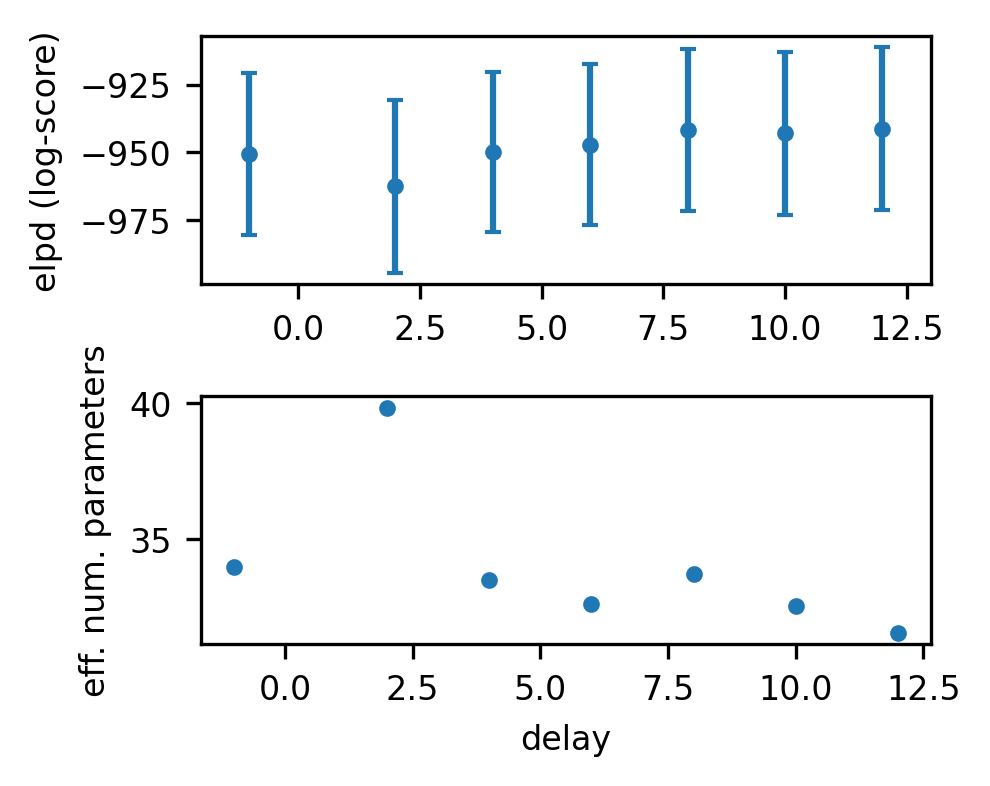

In [122]:
fig,axes = plt.subplots(2,1)

axes[0].errorbar(x=delays,y=[l.loo for l in loo_scores],yerr=[l.loo_se*1.96 for l in loo_scores],ls="",marker=".",capsize=2) #se*1.96 = 95%CI
axes[1].scatter(delays,[l.p_loo for l in loo_scores],marker=".")
axes[1].set_xlabel("delay")
axes[0].set_ylabel("elpd (log-score)")
axes[1].set_ylabel("eff. num. parameters")

fig.tight_layout()

axes[0].set_xlim(-2,13)

plt.show()
plt.close(fig=fig)

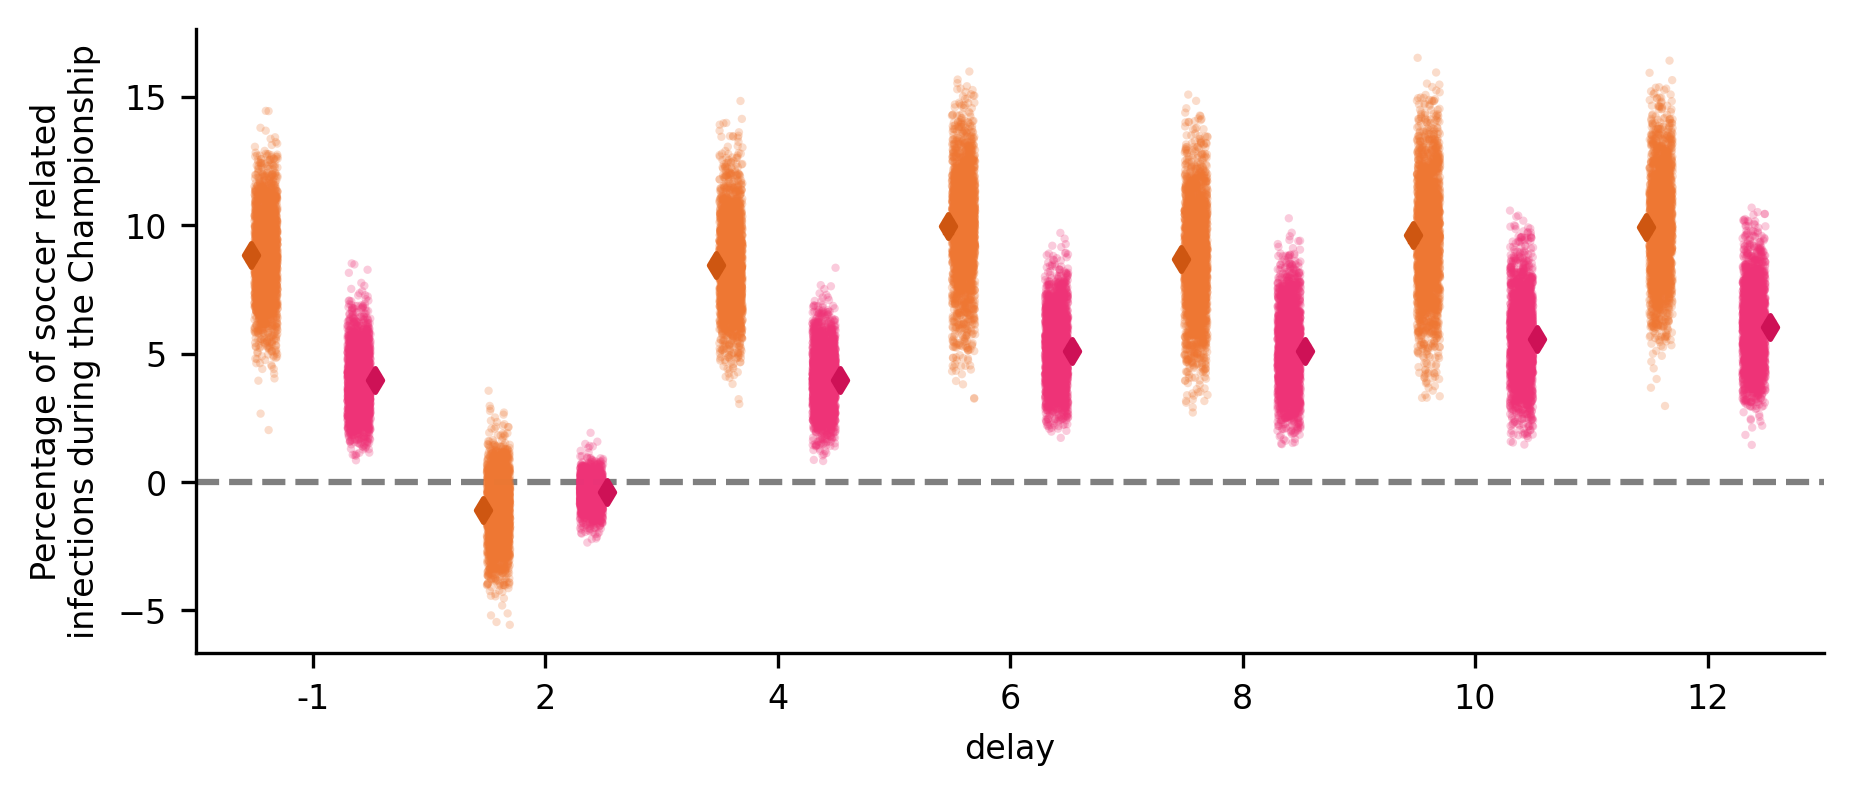

In [123]:
a = plot_relative_from_soccer(traces,models,dls,delays,verbose=False)
a.set_xlabel("delay")
plt.show()
plt.close(fig=a.get_figure())

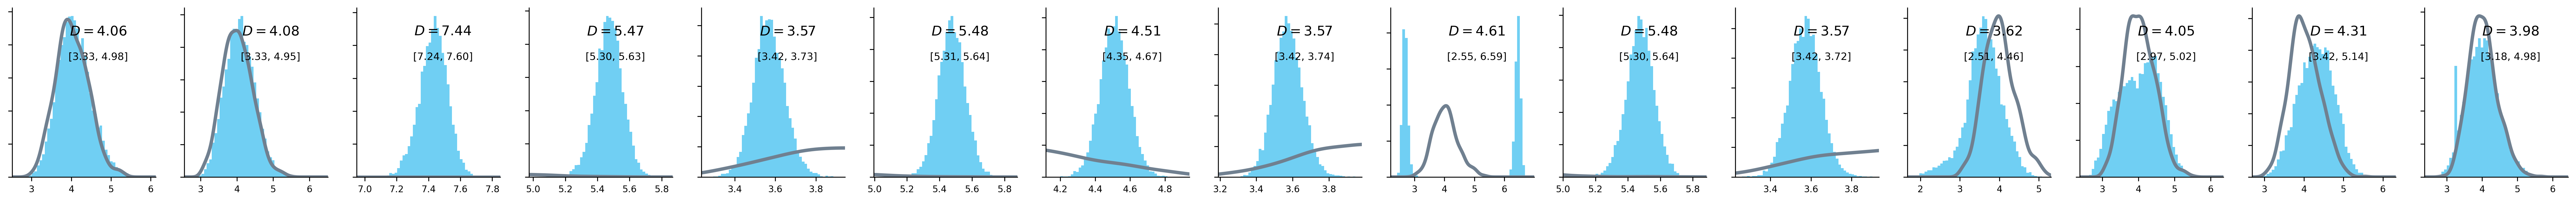

In [146]:
a = plot_delays(traces)
plt.show()
plt.close(fig=a[0].get_figure())

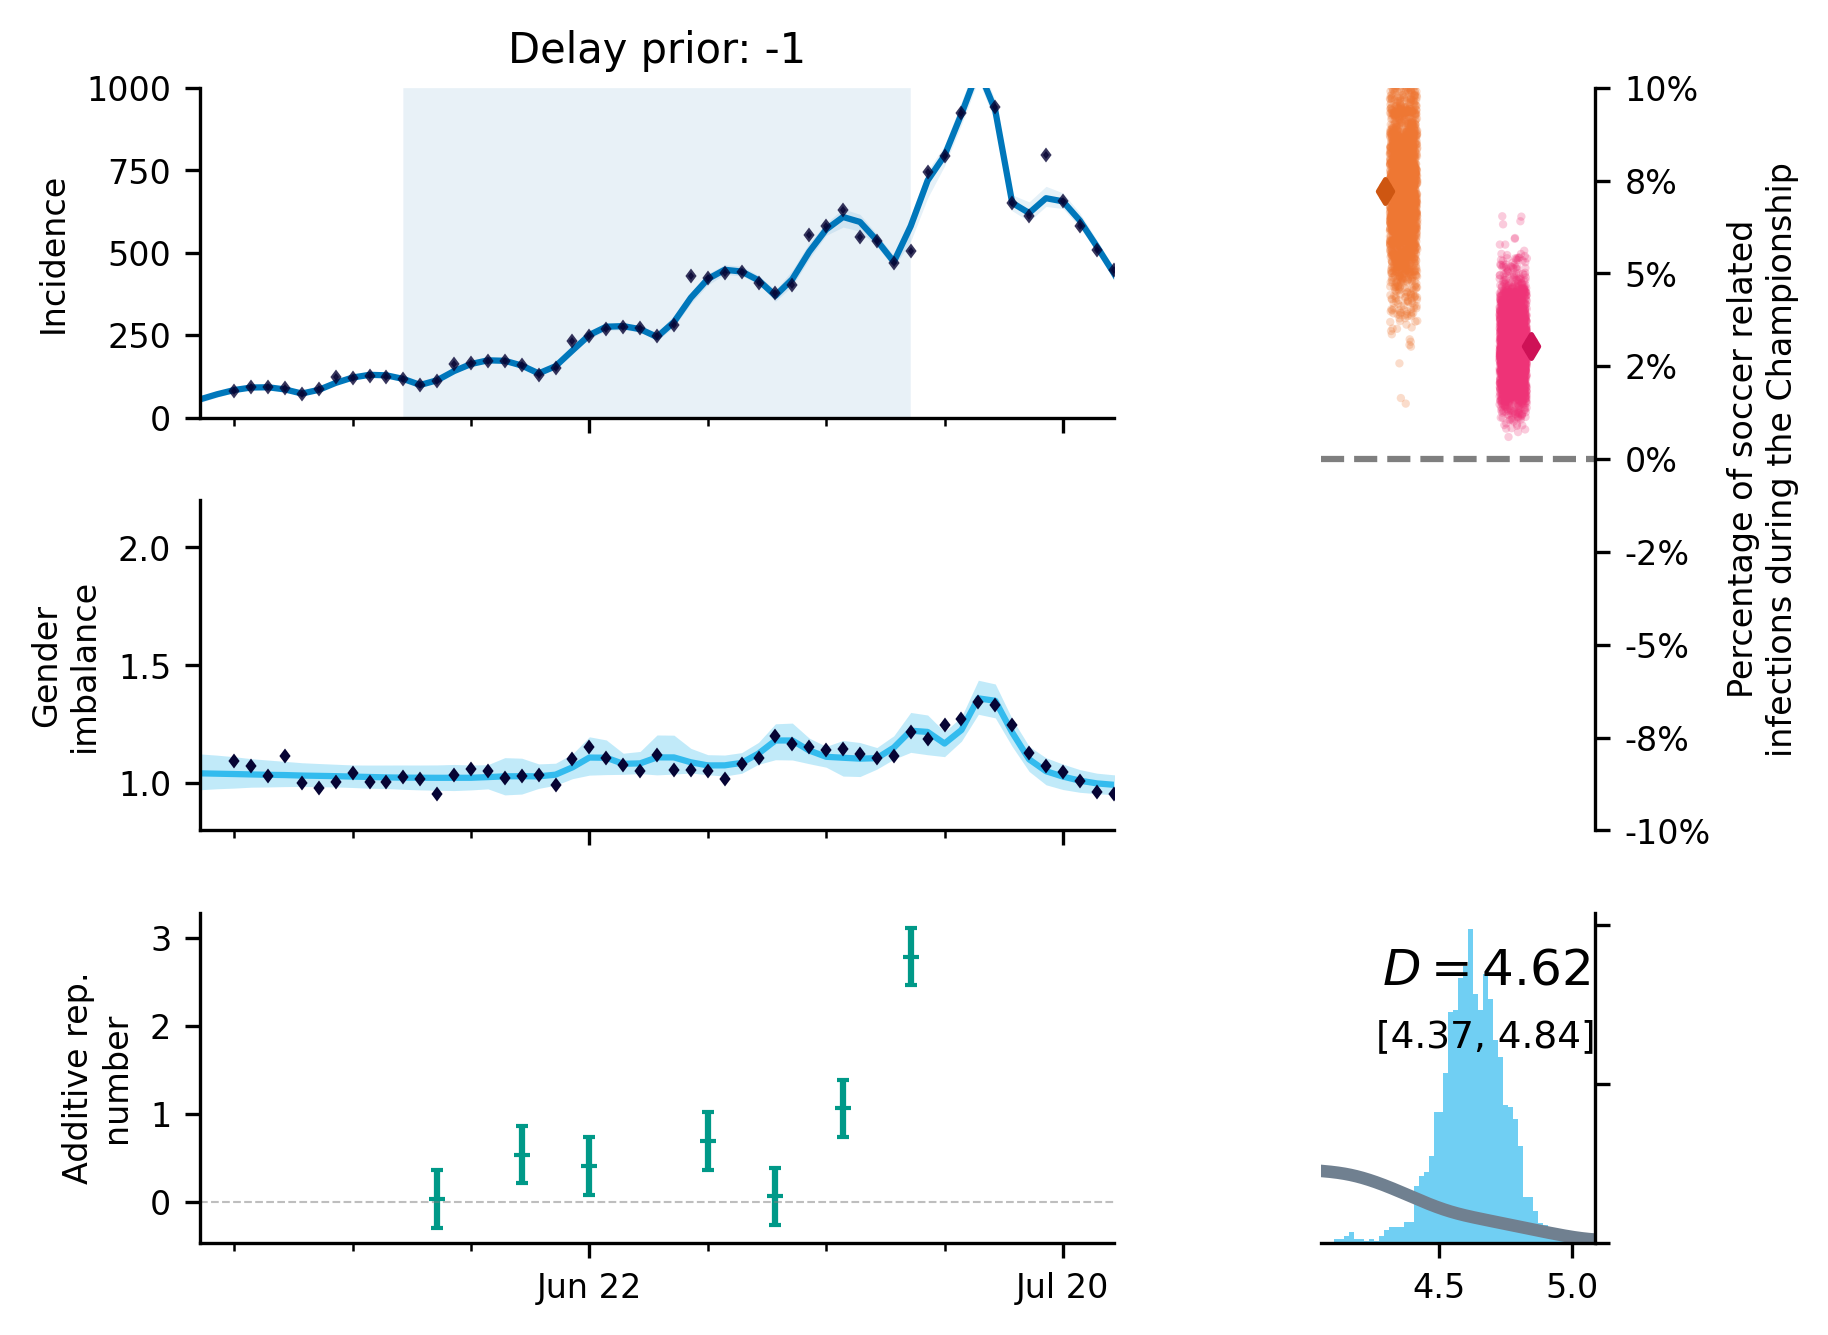

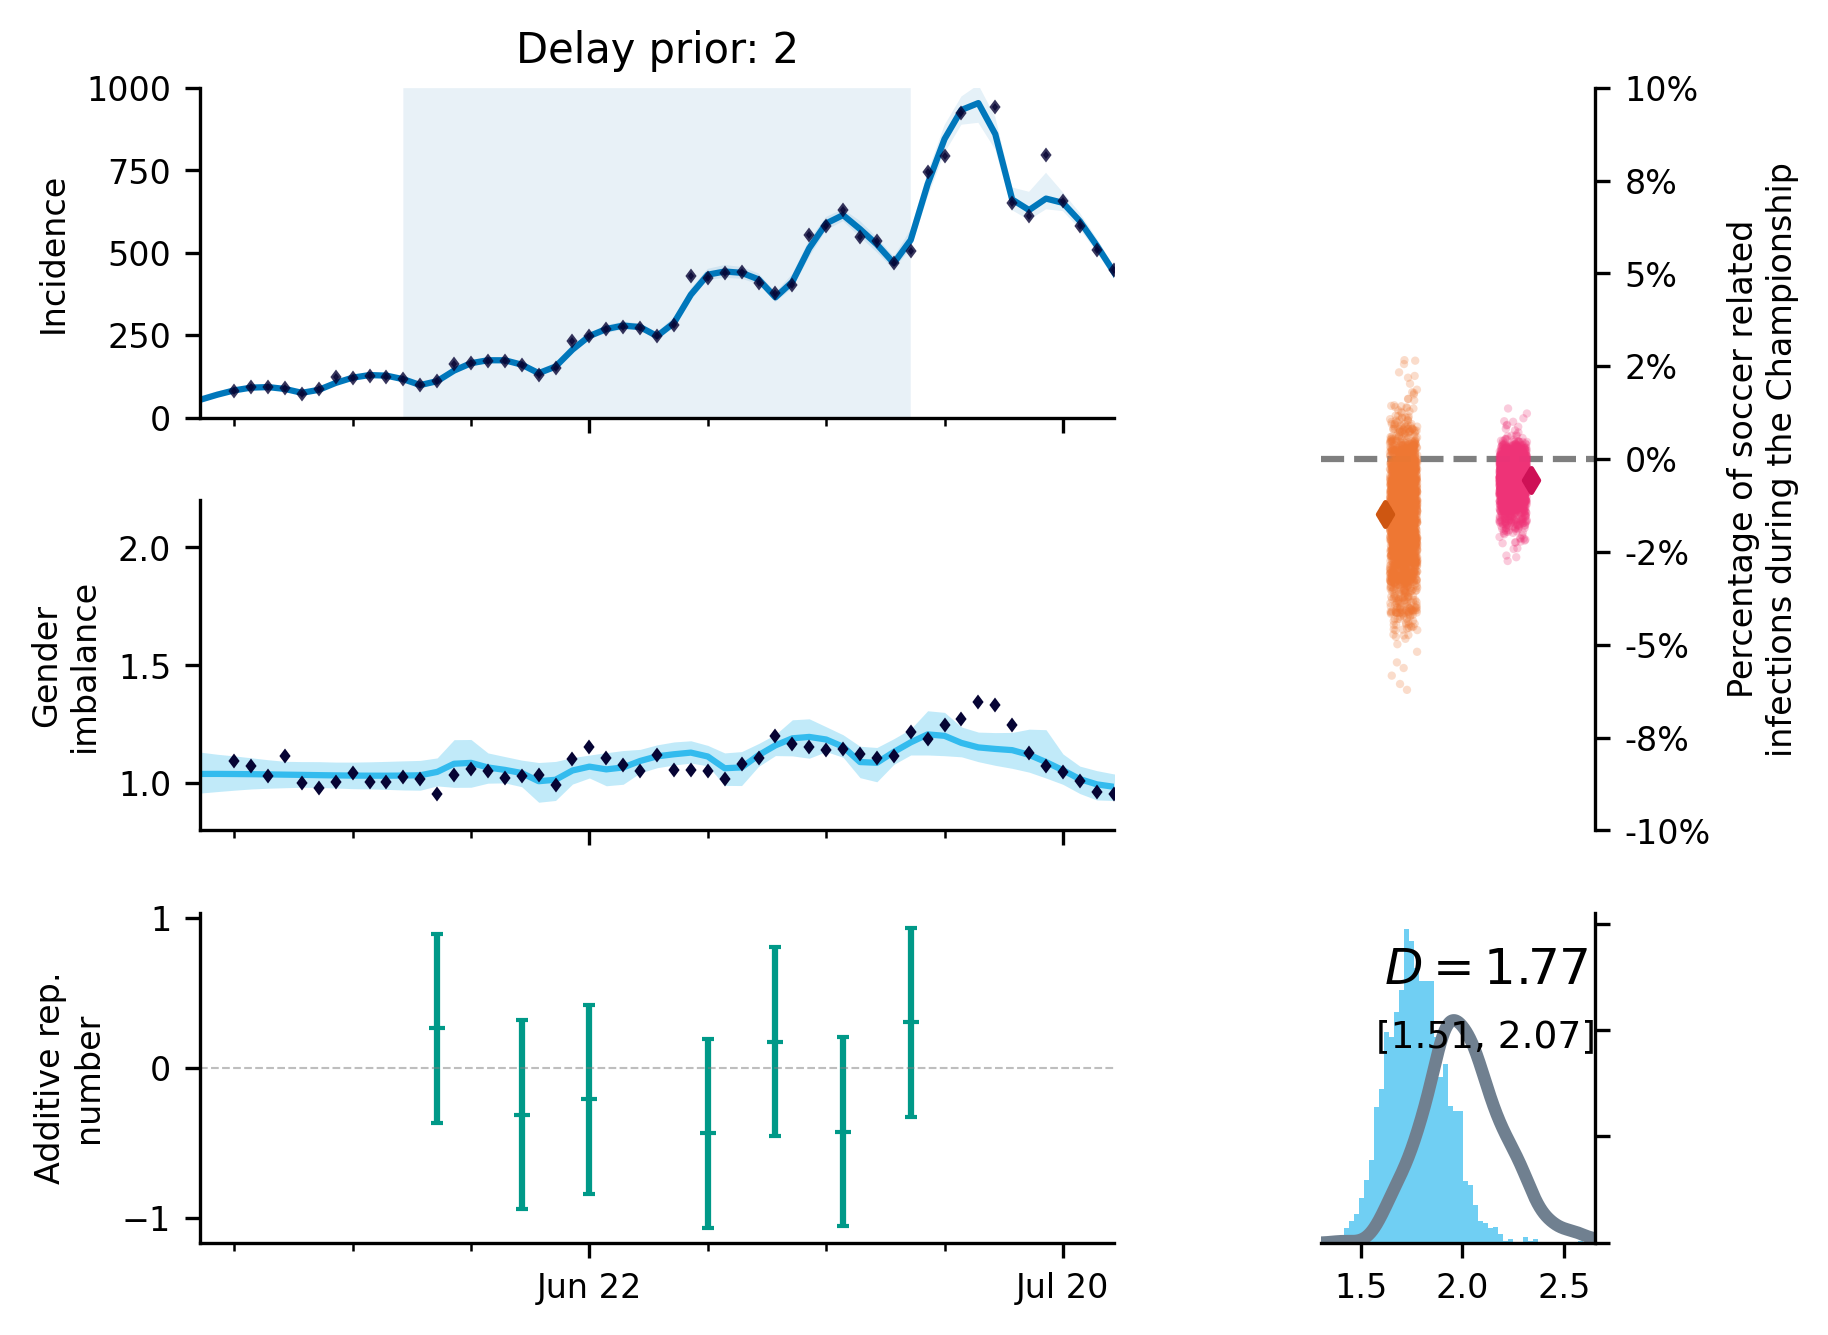

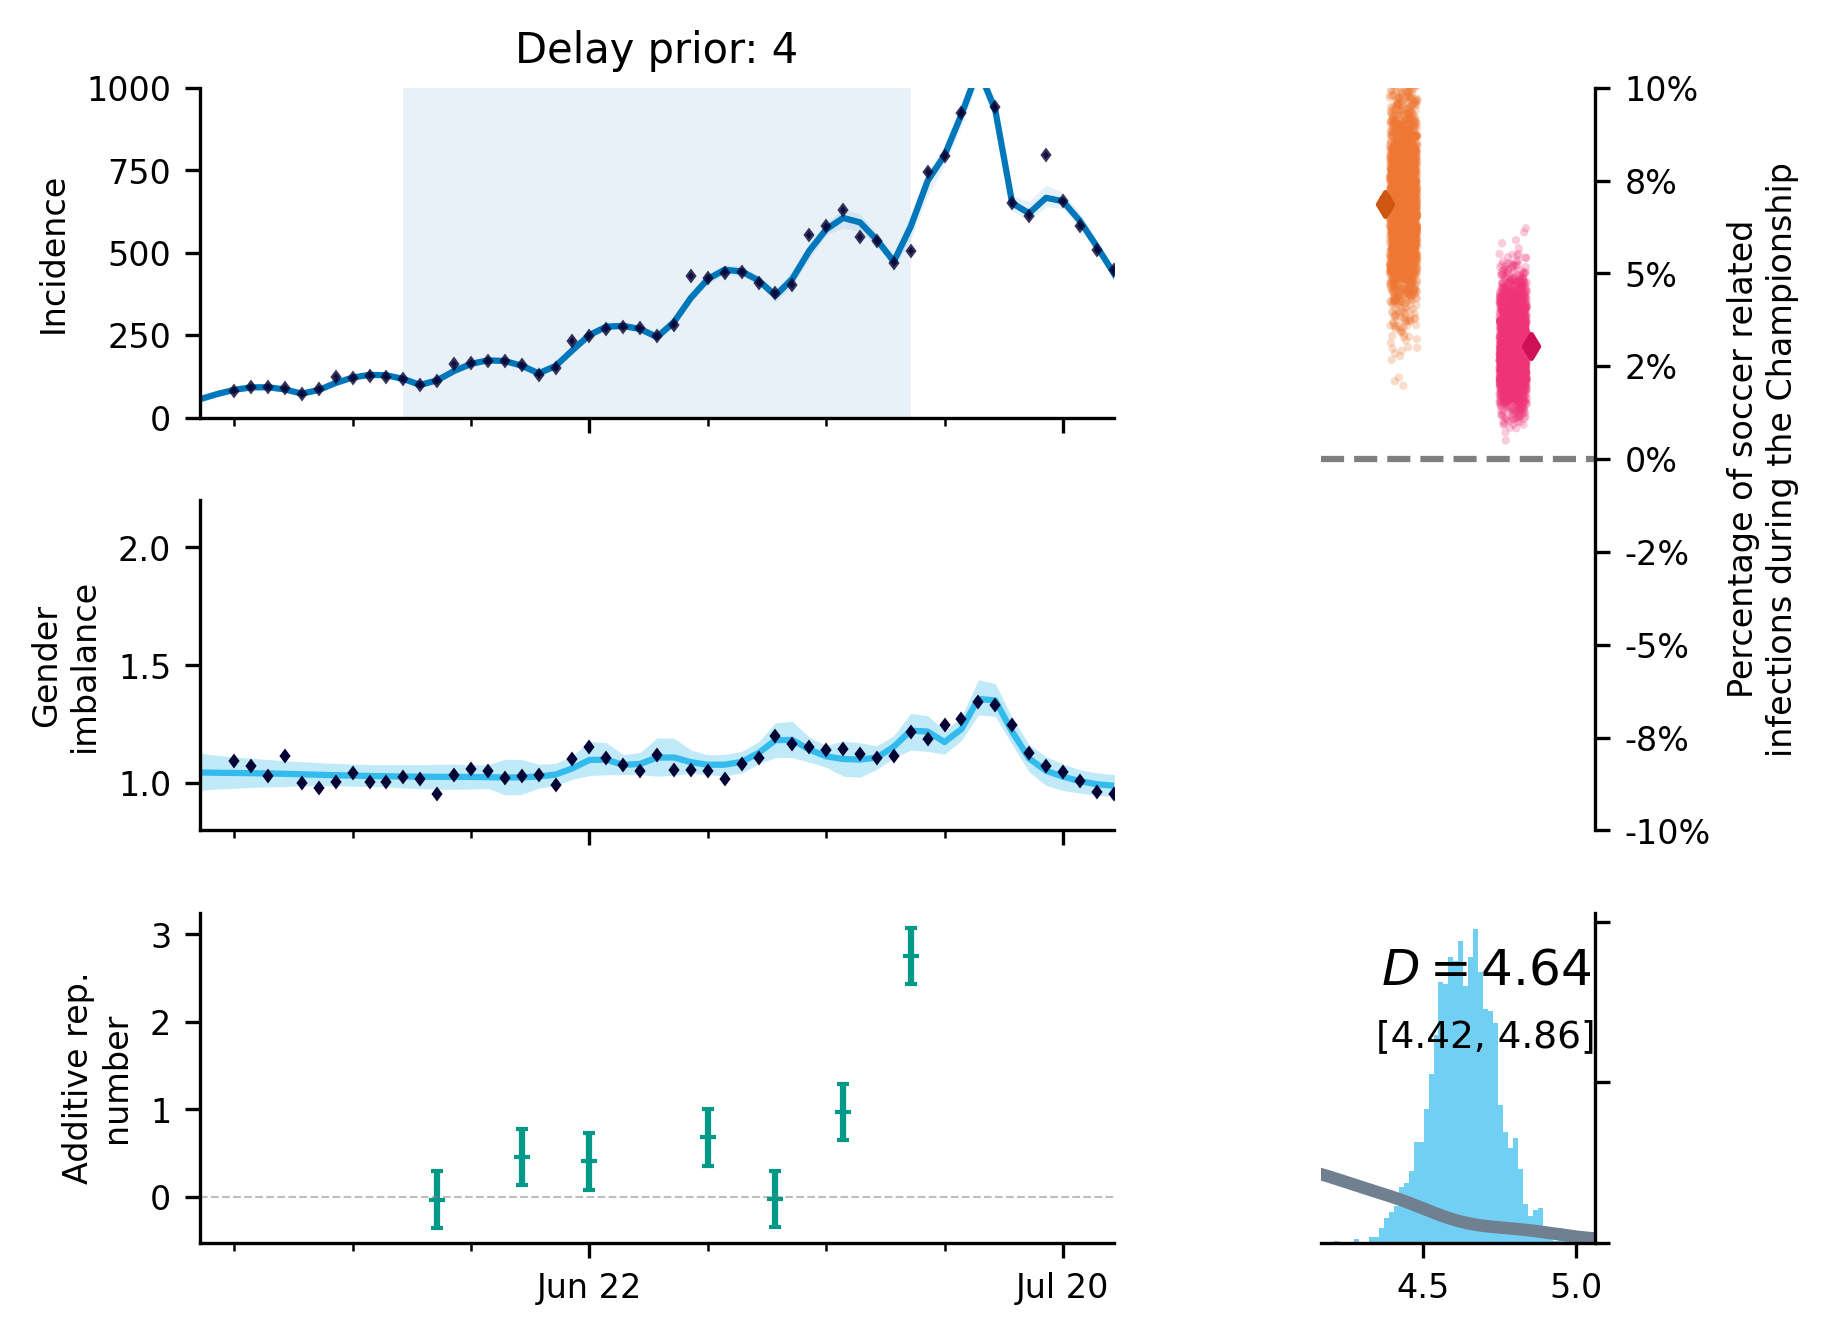

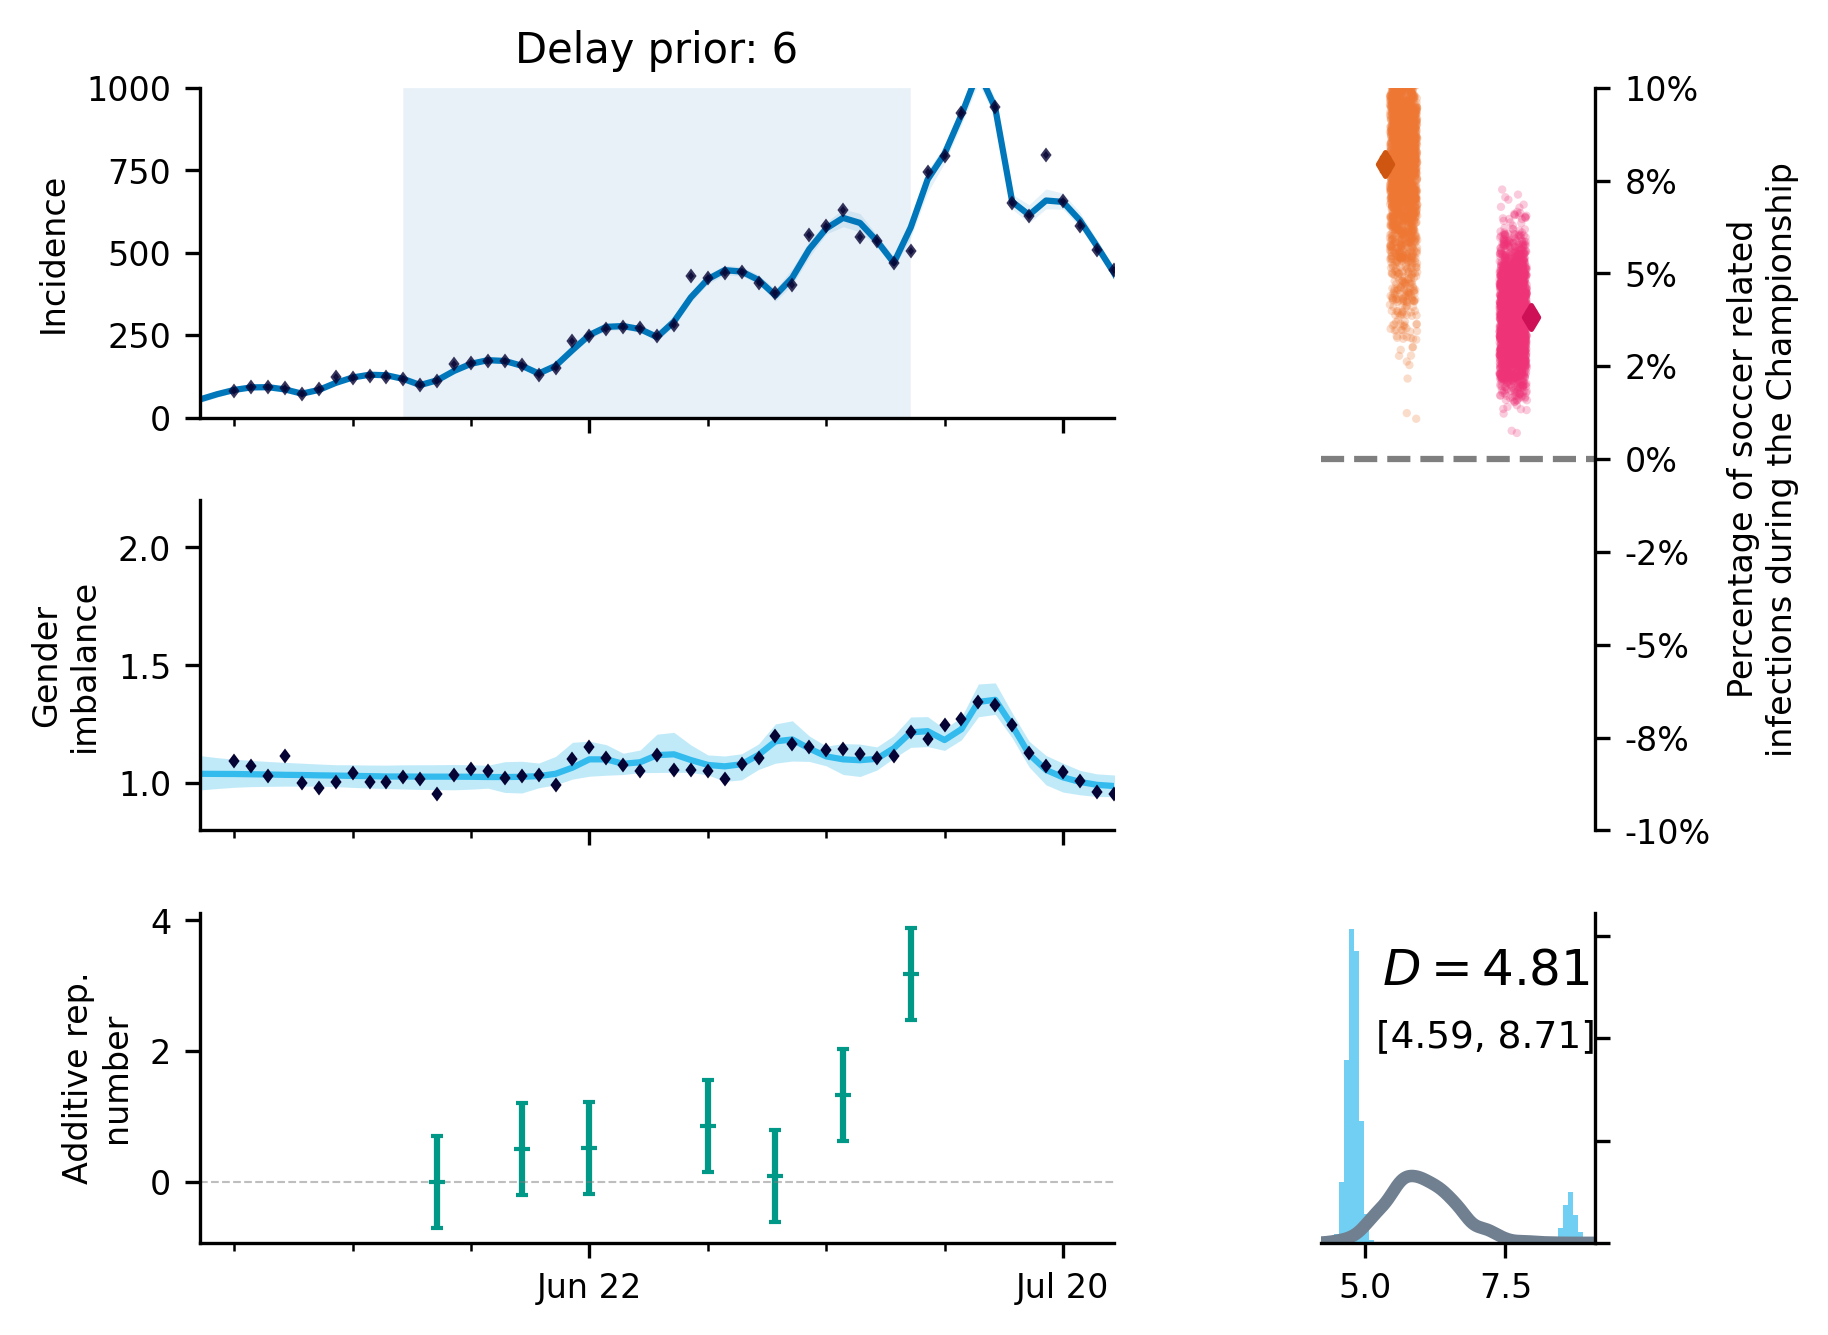

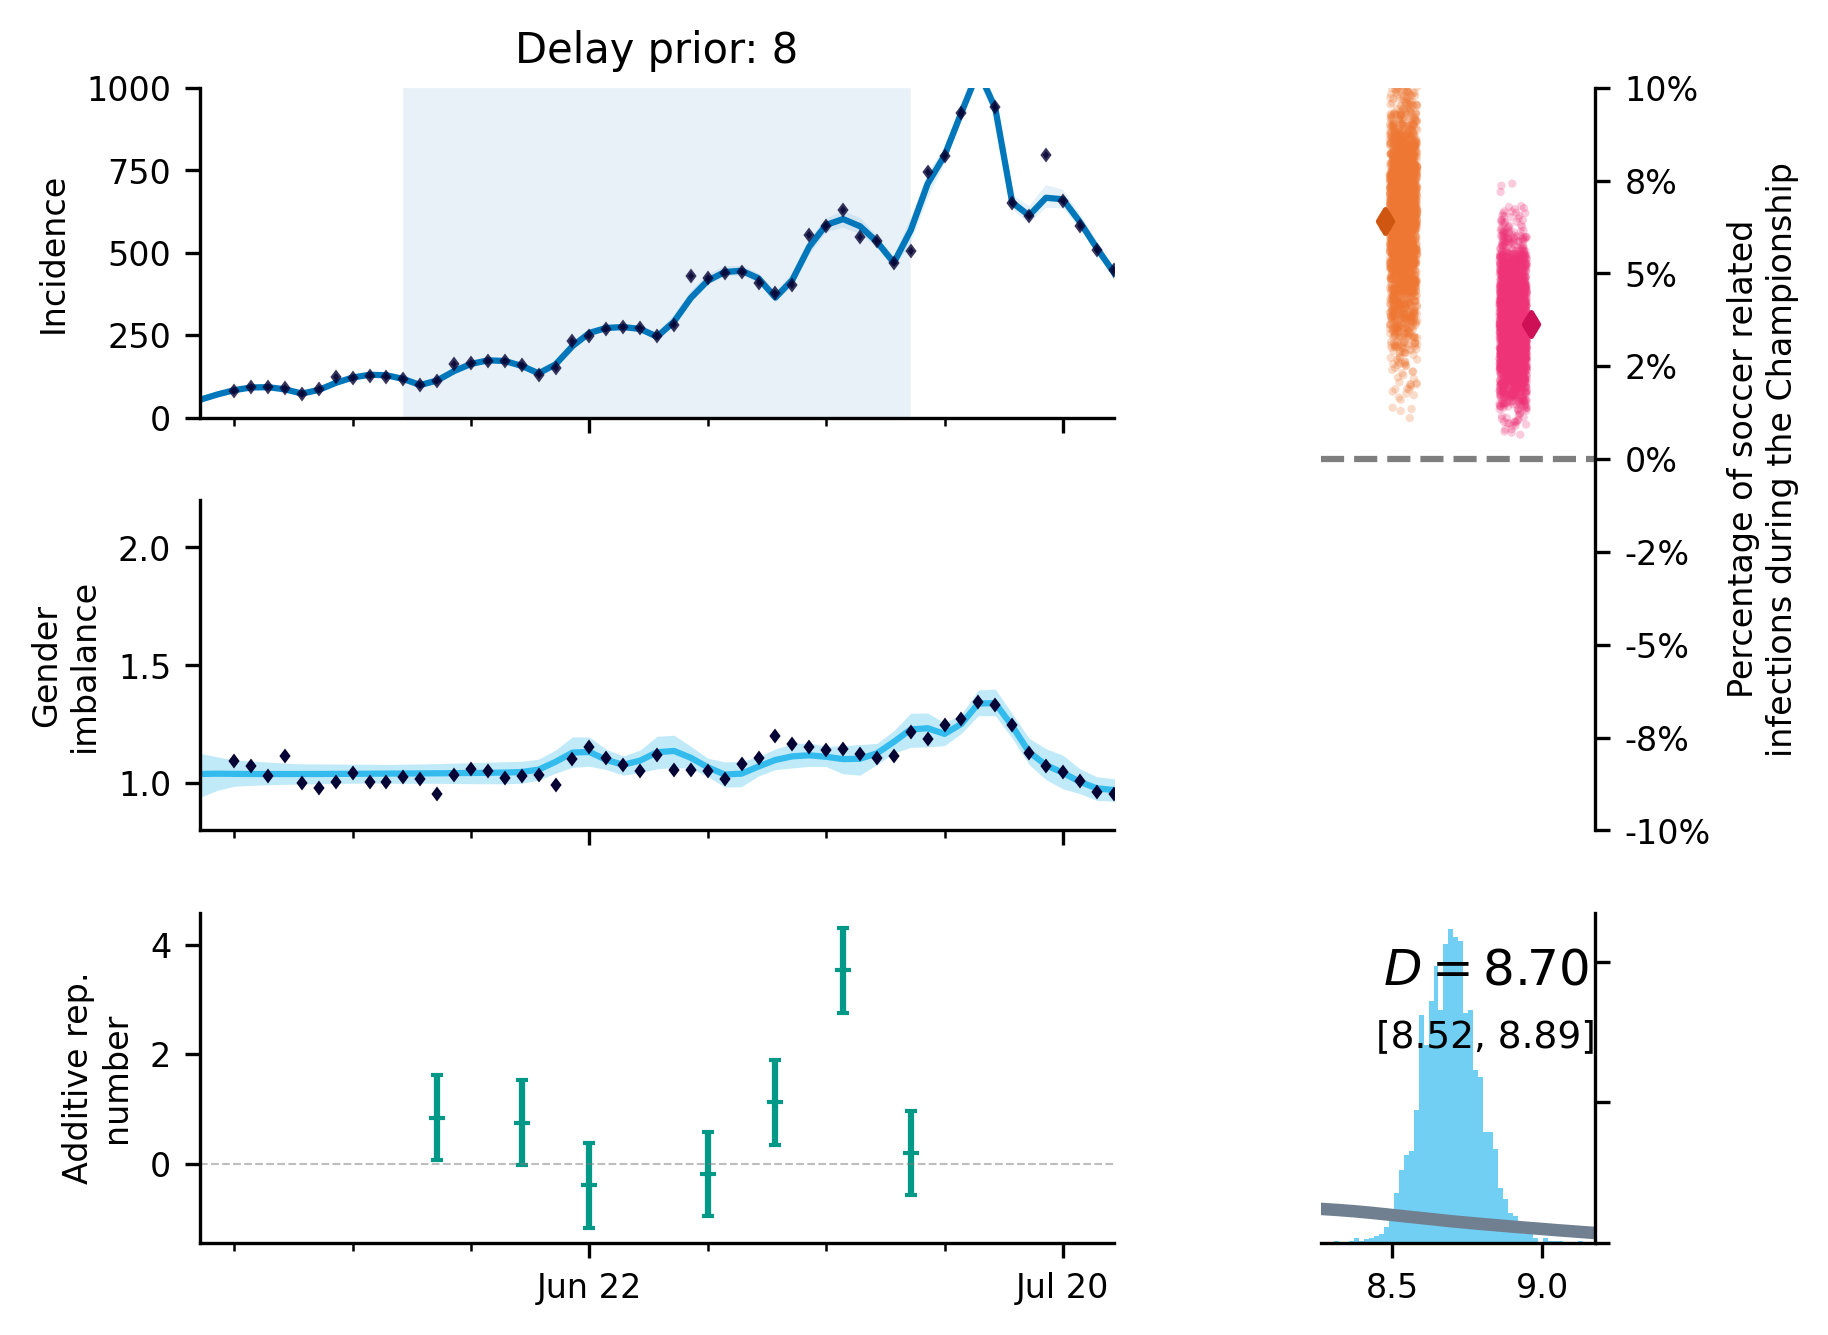

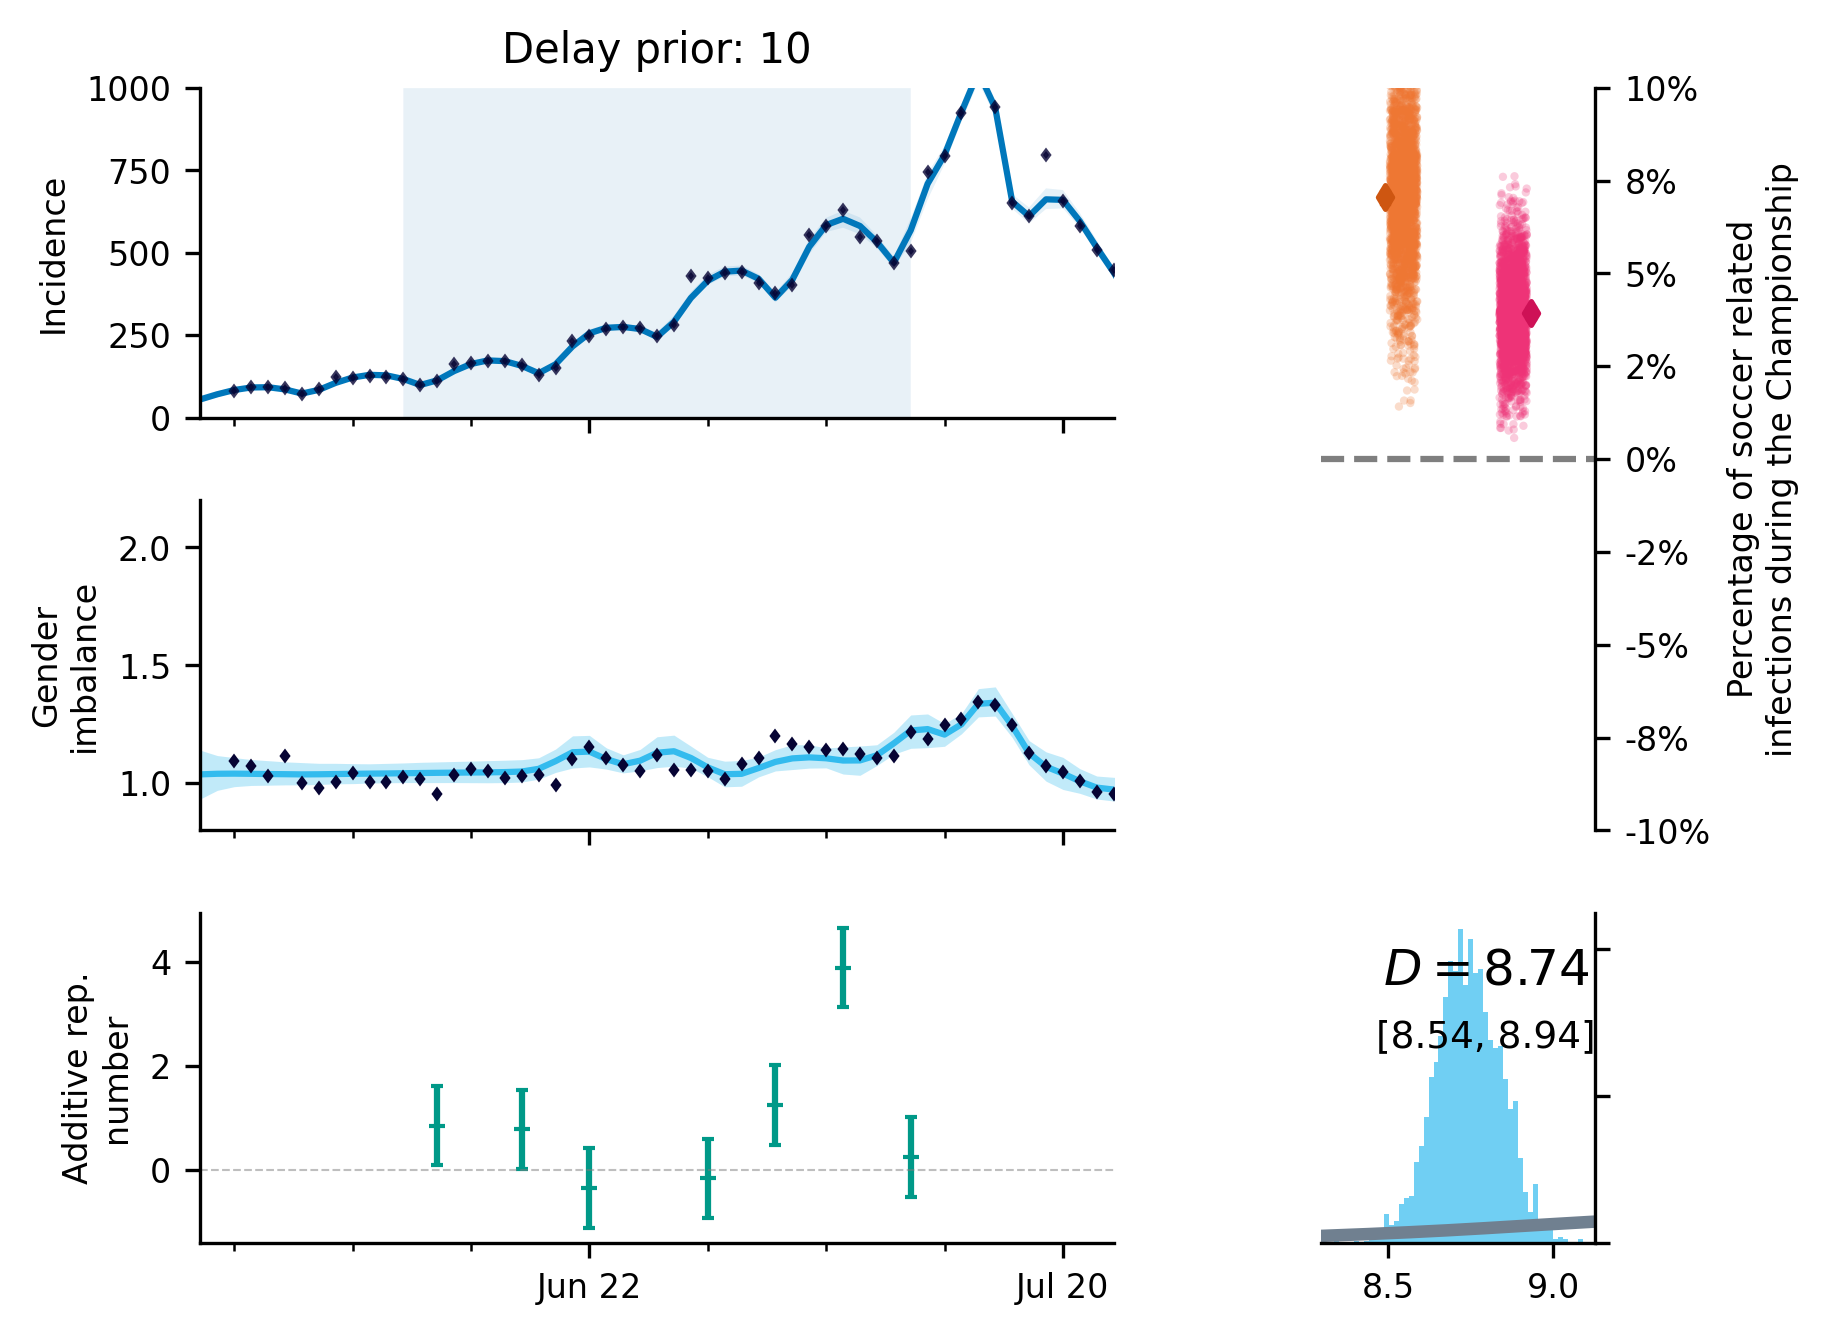

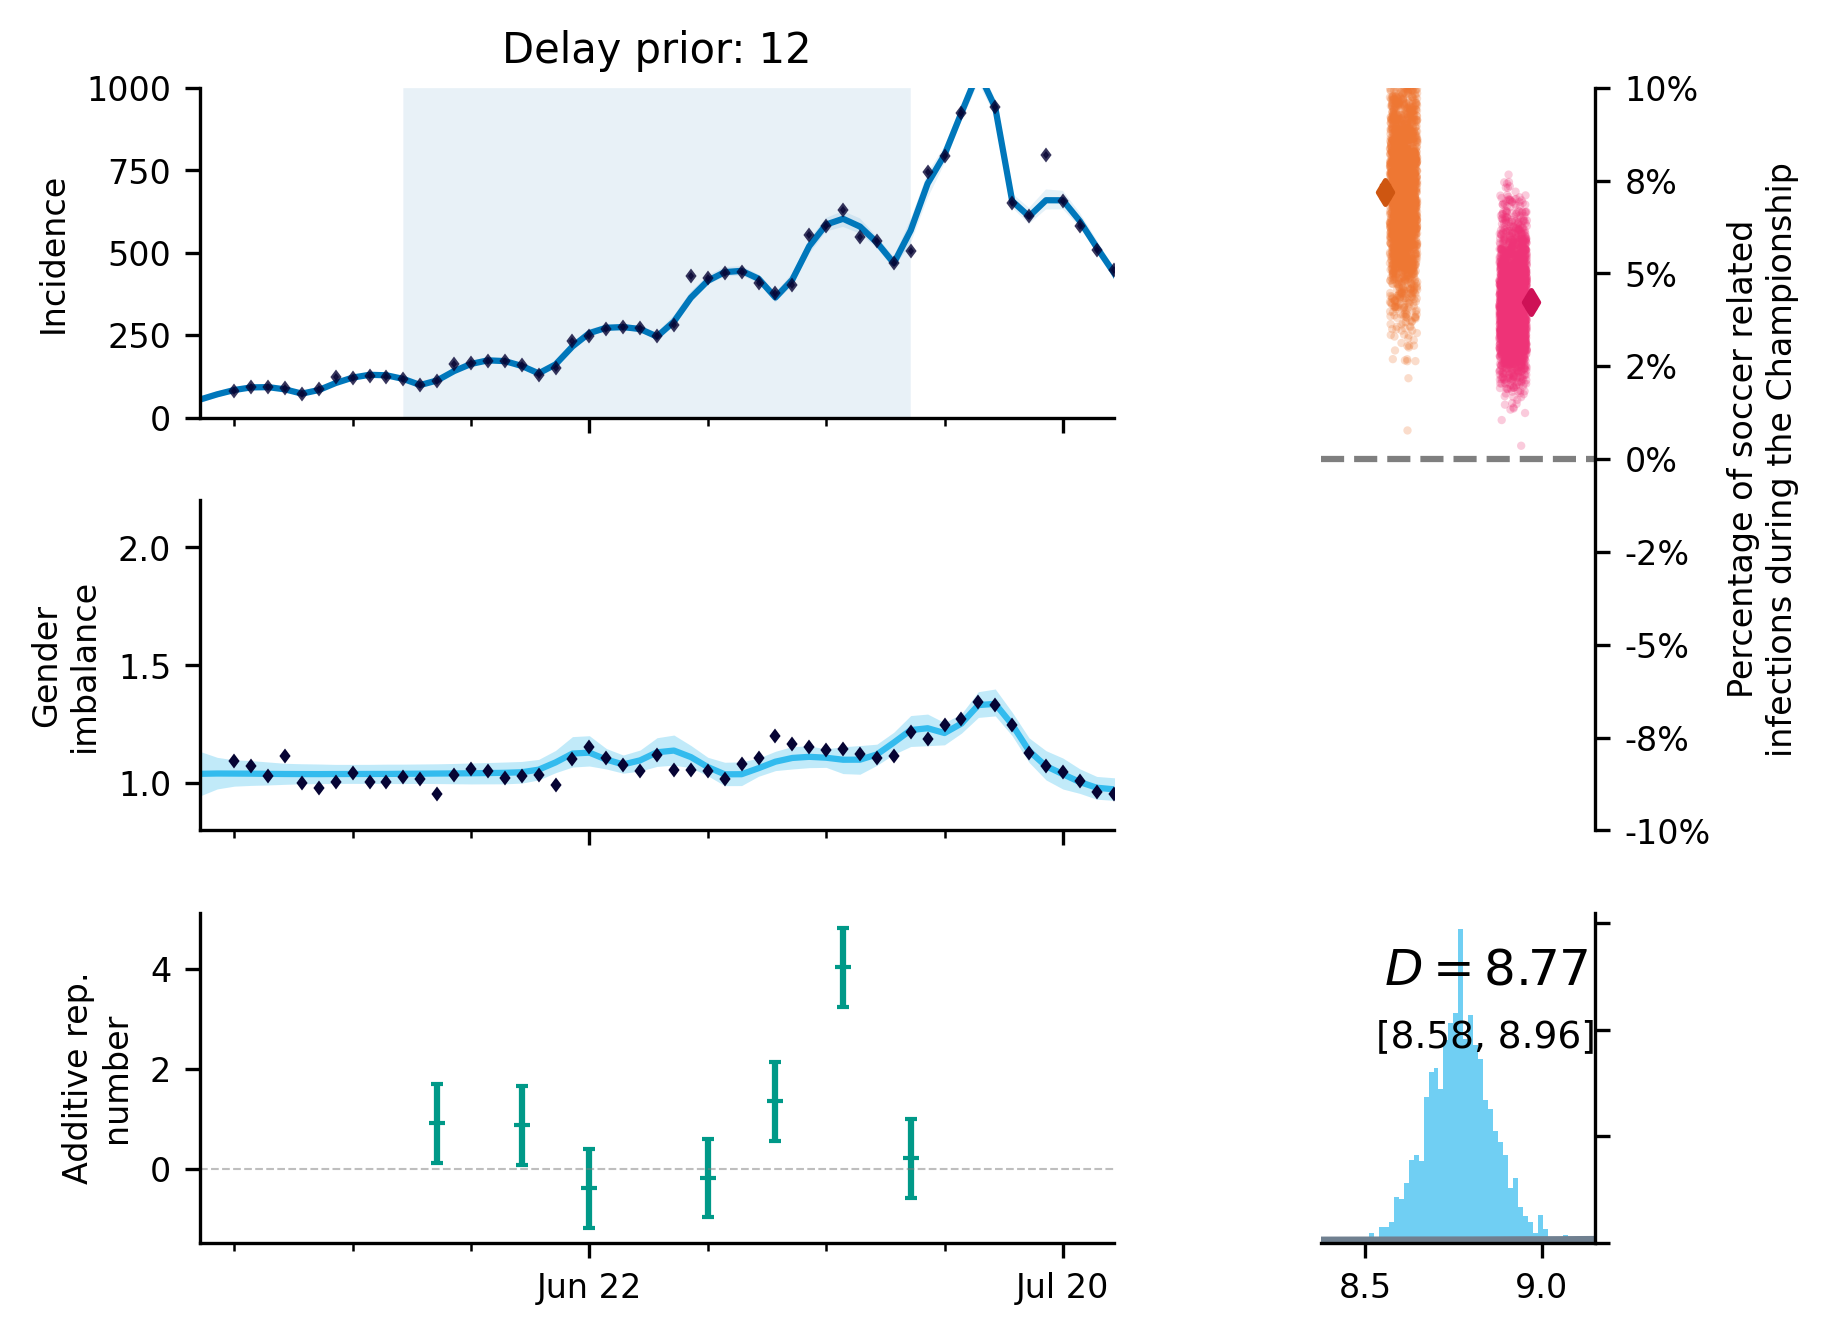

In [126]:
for i ,delay in enumerate(delays):
    fig = covid19_soccer.plot.overview.plot_overview_single(
        traces[i],
        models[i],
        dls[i],
        ylim_fraction=[0.8,2.2],
        ylim_cases=[0,1000],
        ylim_relative=[-10,10],
        title=f"Delay prior: {delay}",
        verbose=False
    )

plt.show()

In [7]:
# Delay
width_delays = [1.0,1.5,2.5]
models, traces, dls = [],[],[]
tune=200
draws=300
max_treedepth=10
country = "Scotland"
for width_delay in width_delays:
    fstr=(f"/data.nst/jdehning/covid_uefa_traces2/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_games=0"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay={-1}"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay={width_delay}"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")   
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    
    models.append(model)
    traces.append(trace)
    dls.append(dl)

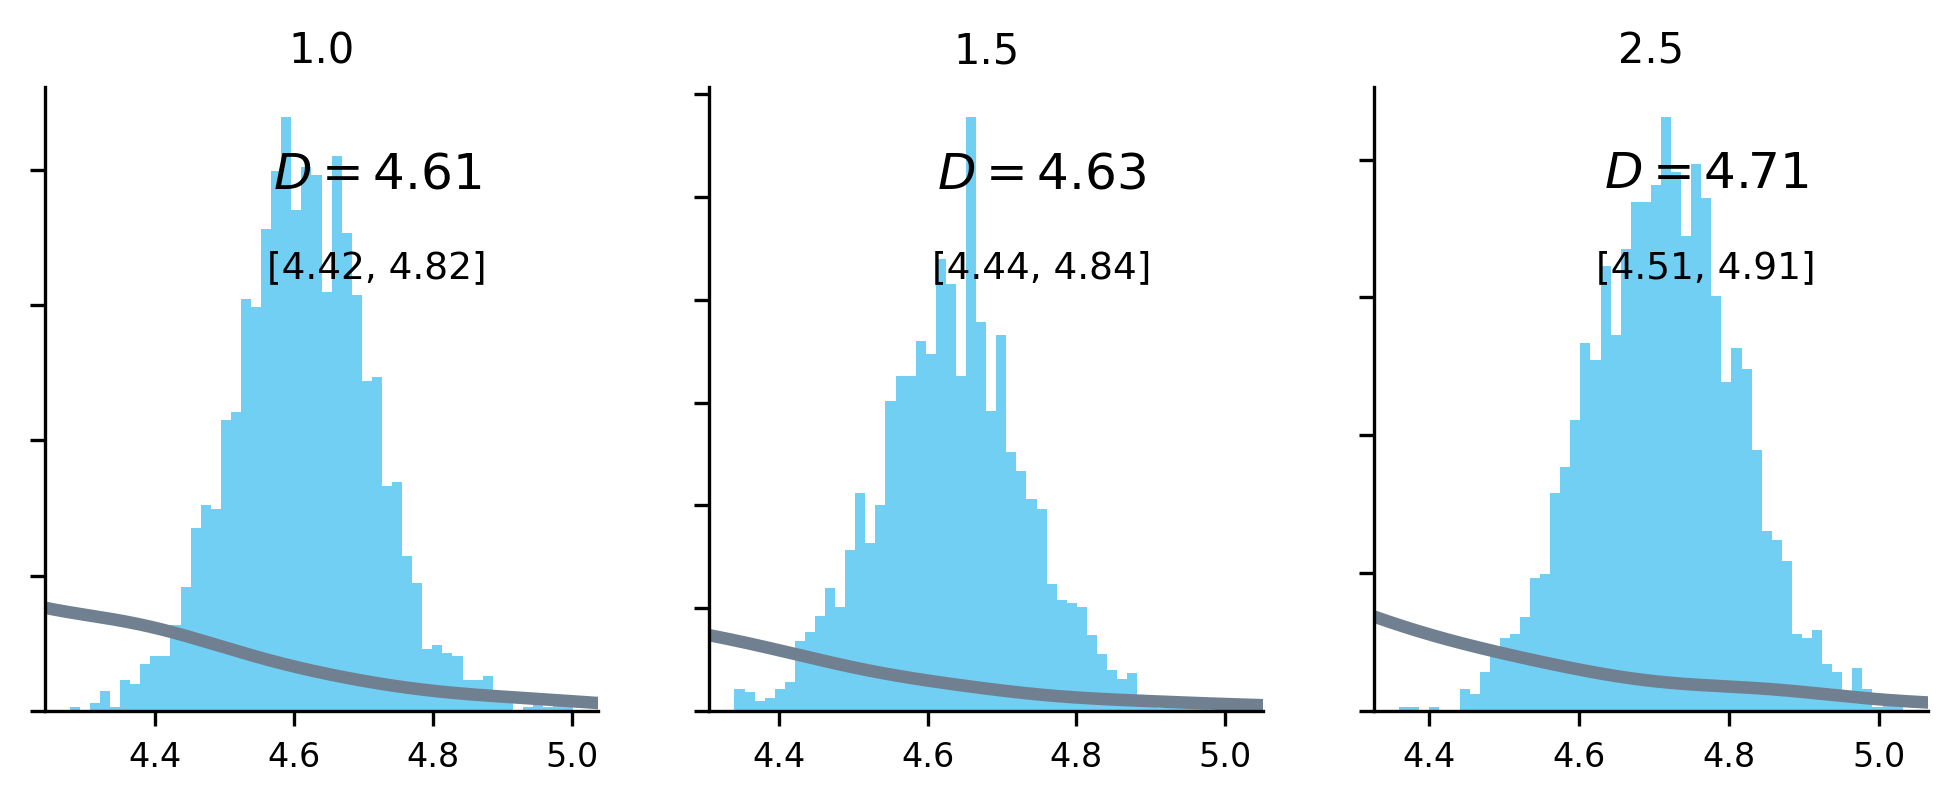

In [8]:
a = plot_delays(traces)

for i,ax in enumerate(a):
    ax.set_title(width_delays[i])
plt.show()
plt.close(fig=a[0].get_figure())

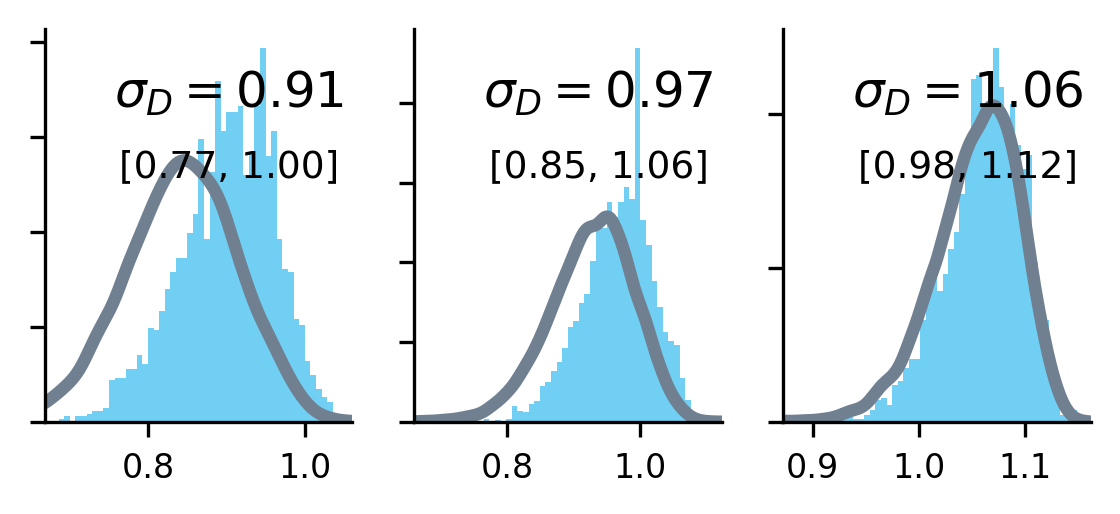

In [10]:
fig,axes = plt.subplots(1,3,figsize=(4.5,1.7))
for i, trace in enumerate(traces):
    covid19_soccer.plot.distribution(
            models[i],
            trace,
            "delay-width",
            nSamples_prior=10000,
            title="",
            dist_math="\sigma_{D}", #What was
            ax = axes[i]
        )
plt.show()

In [11]:
for trace in traces:
    covid19_soccer.plot.plot_overview_single(
        trace,
        models[i],
        dls[i]
    )
    plt.show()

CI [50,2.5,97.5] ['England']:
	male [0.0665905  0.03702005 0.09498651]
	female [0.02923373 0.01530354 0.04753189]
CI [50,2.5,97.5] ['England']:
	male [0.07456396 0.04160286 0.10700417]
	female [0.03425152 0.01664469 0.05562396]
CI [50,2.5,97.5] ['England']:
	male [0.08279747 0.04943422 0.11477785]
	female [0.0401684  0.0193381  0.06184363]
